<a href="https://colab.research.google.com/github/Roweida-Mohammed/Code_For_Santander_Customer_Transaction_Prediction/blob/master/Code_For_Santander_Customer_Transaction_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importing all the necessary libraries

In [0]:
import numpy as np
import pandas as pd
from pandas import DataFrame as df 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.utils import resample
from sklearn.feature_selection import SelectFromModel 
from sklearn.model_selection import GridSearchCV 
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor  
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier

##For plotting issues

In [0]:
acc = []; pre = [] ; rec = [] ; f = [] ; ro = []

##Reading the training dataset

In [0]:
trainDataSet = pd.read_csv("train.csv")
trainDataSet.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,...,13.2070,5.8442,4.7086,5.7141,-1.0410,20.5092,3.2790,-5.5952,7.3176,5.7690,-7.0927,-3.9116,7.2569,-5.8234,25.6820,10.9202,-0.3104,8.8438,-9.7009,2.4013,-4.2935,9.3908,-13.2648,3.1545,23.0866,-5.3000,5.3745,-6.2660,10.1934,-0.8417,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,...,31.8833,5.9684,7.2084,3.8899,-11.0882,17.2502,2.5881,-2.7018,0.5641,5.3430,-7.1541,-6.1920,18.2366,11.7134,14.7483,8.1013,11.8771,13.9552,-10.4701,5.6961,-3.7546,8.4117,1.8986,7.2601,-0.4639,-0.0498,7.9336,-12.8279,12.4124,1.8489,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,...,33.5107,5.6953,5.4663,18.2201,6.5769,21.2607,3.2304,-1.7759,3.1283,5.5518,1.4493,-2.6627,19.8056,2.3705,18.4685,16.3309,-3.3456,13.5261,1.7189,5.1743,-7.6938,9.7685,4.8910,12.2198,11.8503,-7.8931,6.4209,5.9270,16.0201,-0.2829,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [0]:
trainDataSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [0]:
trainDataSet.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,7.567236,0.394340,-3.245596,14.023978,8.530232,7.537606,14.573126,9.333264,-5.696731,15.244013,12.438567,13.290894,17.257883,4.305430,3.019540,10.584400,13.667496,-4.055133,-1.137908,5.532980,5.053874,-7.687740,10.393046,-0.512886,14.774147,11.434250,3.842499,2.187230,5.868899,10.642131,...,24.259300,5.633293,5.362896,11.002170,-2.871906,19.315753,2.963335,-4.151155,4.937124,5.636008,-0.004962,-0.831777,19.817094,-0.677967,20.210677,11.640613,-2.799585,11.882933,-1.014064,2.591444,-2.741666,10.085518,0.719109,8.769088,12.756676,-3.983261,8.970274,-10.335043,15.377174,0.746072,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,1.235070,5.500793,5.970253,0.190059,4.639536,2.247908,0.411711,2.557421,6.712612,7.851370,7.996694,5.876254,8.196564,2.847958,0.526893,3.777245,0.285535,5.922210,1.523714,0.783367,2.615942,7.965198,2.159891,2.587830,4.322325,0.541614,5.179559,3.119978,2.249730,4.278903,...,10.880263,0.217938,1.419612,5.262056,5.457784,5.024182,0.369684,7.798020,3.105986,0.369437,4.424621,5.378008,8.674171,5.966674,7.136427,2.892167,7.513939,2.628895,8.579810,2.798956,5.261243,1.371862,8.963434,4.474924,9.318280,4.725167,3.189759,11.574708,3.944604,0.976348,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,3.970500,-20.731300,-26.095000,13.434600,-6.011100,1.013300,13.076900,0.635100,-33.380200,-10.664200,-12.402500,-5.432200,-10.089000,-5.322500,1.209800,-0.678400,12.720000,-24.243100,-6.166800,2.089600,-4.787200,-34.798400,2.140600,-8.986100,1.508500,9.816900,-16.513600,-8.095100,-1.183400,-6.337100,...,-7.452200,4.852600,0.623100,-6.531700,-19.997700,3.816700,1.851200,-35.969500,-5.250200,4.258800,-14.506000,-22.479300,-11.453300,-22.748700,-2.995300,3.241500,-29.116500,4.952100,-29.273400,-7.856100,-22.037400,5.416500,-26.001100,-4.808200,-18.489700,-22.583300,-3.022300,-47.753600,4.412300,-2.554300,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.26

##Explore the data and fill the empty fields (features)

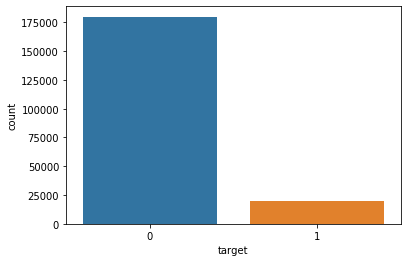

In [0]:
#checking target column 
sns.countplot(trainDataSet['target'])

In [0]:
#checking for null values
trainDataSet.columns[trainDataSet.isnull().values.any()]

array([], shape=(0, 202), dtype=object)

In [0]:
#checking count for possible values of target
trainDataSet.groupby('target').count()['ID_code']

target
0    179902
1     20098
Name: ID_code, dtype: int64

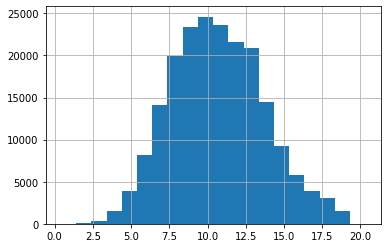

In [0]:
#Visualization of the underlying frequency distribution
trainDataSet.var_0.hist(bins=20)

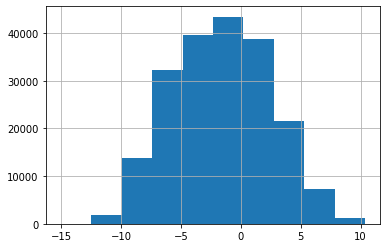

In [0]:
trainDataSet.var_1.hist()

In [0]:
# Compute the Correlation matrix
corr=trainDataSet.iloc[:,:20].corr()

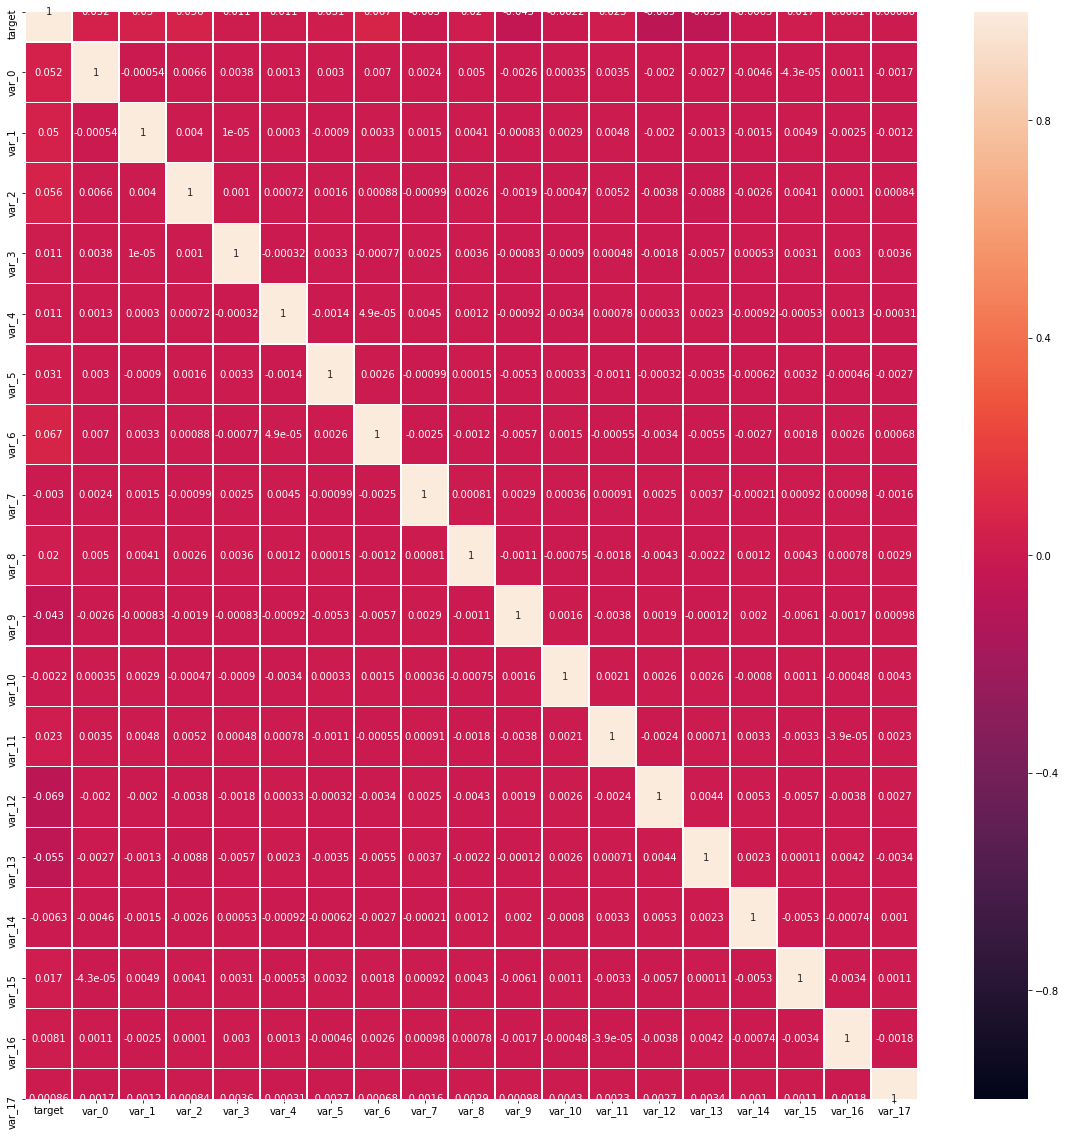

In [0]:
# Set the matplotlib figure 
fig, ax=plt.subplots(figsize=(20,20))
# Generate a custom diverging colormap
Cmap=sns.diverging_palette(220,10,as_cmap=True)

# Draw the heatmap
_= sns.heatmap(corr,  ax=ax, annot=True,   vmin=-1, linewidths=0.2)

In [0]:
#Spliting the dataset to train (x) and target (y)
y = trainDataSet['target']
X = trainDataSet.drop(['target', 'ID_code'], axis=1)

In [0]:
#Scaling dataset
sc = StandardScaler()
sc.fit(X)
x_scaled = sc.transform(X)
x_scaled=pd.DataFrame(x_scaled,columns=X.columns)
x_scaled.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,-0.577102,-1.273737,0.451707,-0.833709,0.235571,-0.536430,-0.334926,0.608751,-1.561580,-1.473796,0.460091,1.076623,-0.054077,-1.714773,0.561098,-0.009778,-1.401636,-0.229802,-1.395940,2.285292,-0.468989,-0.126734,-0.606166,-1.039947,1.005683,-0.823003,-0.184673,0.479492,-0.768964,0.360340,0.926437,1.162587,-1.299824,0.489773,-0.447275,1.300500,-0.484245,0.897088,-1.396490,0.789254,...,-0.808962,-1.468275,-1.230618,-1.133356,1.749415,-1.323871,-0.711244,0.442890,1.500647,-0.400904,-1.075697,-1.411980,0.122226,0.642079,-0.231051,-1.347890,-0.974846,0.700359,-0.291946,-0.311275,-1.076447,-0.779321,0.261797,1.251424,1.404031,2.086632,0.900016,-0.810464,0.556997,-0.164257,0.263374,-1.149158,0.817469,-0.411013,0.168705,-1.578117,1.022131,-0.373968,-1.026398,0.214135
1,0.269959,-0.622138,1.190360,-0.688846,0.790975,1.539900,0.244461,-0.003525,0.858974,0.419300,-0.144987,1.893408,-0.000409,-0.025160,-0.935586,-2.120000,1.757336,-1.473077,-0.948119,2.017368,-1.678317,-1.771135,1.491237,0.668183,-0.954799,0.782756,-1.302434,-0.932390,-0.621140,-1.722433,-0.202250,-1.165592,0.695096,1.063517,-0.118257,-0.599010,0.196242,-0.011334,0.040634,0.741083,...,0.480256,1.078324,-1.086283,0.918394,-0.392137,-0.832228,0.640994,1.727411,-0.339675,0.443627,1.252712,1.102749,0.255461,1.037661,1.408807,-0.395487,-0.590320,1.783707,-0.738204,3.031050,-0.542085,-0.435700,-1.743656,0.146464,1.050349,-0.186013,-0.412563,-0.483543,-0.522151,-1.129387,0.966611,0.093605,0.443623,1.908764,-0.817594,1.522342,1.067654,-0.129400,0.825417,0.505685
2,-0.681113,-0.276066,0.516988,0.536516,-0.305477,-0.511033,1.769839,-0.564749,-1.561370,-1.307408,-0.130752,-1.343197,0.888789,-0.262491,-0.005875,0.179918,-0.647163,0.589523,-1.342815,1.005285,0.759841,0.107340,-1.085317,0.937877,-1.299019,-1.575276,-0.665103,-1.158352,0.399967,0.416687,-0.428711,0.968919,-0.685601,0.987446,-0.718871,0.051395,0.804550,0.473703,0.058326,0.058332,...,-1.015814,0.967742,-0.460899,-1.004946,0.335468,0.237541,0.853879,-0.185182,0.766417,0.359986,-1.601890,-0.572671,-1.448003,-0.862364,0.766677,-0.249092,0.331276,-1.156053,-1.012477,-0.067934,-0.294957,-0.506407,-1.560110,-1.254681,1.108568,-0.278666,-1.127290,0.351547,-1.314146,-1.626240,-0.072093,0.777997,-0.174131,-0.412316,1.151591,2.297370,-1.617906,-0.695141,-0.381449,0.356681
3,0.125158,-0.129426,-0.667575,0.195355,0.927992,0.410672,0.500633,-0.474201,-1.843910,0.548767,0.347543,1.014331,-0.934857,0.741492,-0.480762,0.641408,0.551235,0.784619,0.088977,0.160959,1.192958,-0.573410,0.883010,-0.562999,0.410618,0.242366,0.822099,0.152265,0.477453,-0.846035,-0.948135,0.022063,-0.796119,-1.988413,-1.523135,-1.884007,1.918310,-1.340964,-0.343157,0.000871,...,0.700720,1.537629,1.300009,-1.351618,-1.505430,-0.411123,-1.015017,0.185862,-1.407938,-0.793123,-1.615767,-0.996695,-0.182207,2.076768,-0.765424,-1.223761,1.953266,0.788267,-1.102129,1.109222,-0.192528,-1.220110,0.131590,-0.337210,-1.418782,0.832451,-0.325002,-0.215372,-0.751604,1.129547,0.270216,-0.891456,-0.818468,-0.478548,1.607869,-0.789517,-0.959020,1.501744,0.697118,-0.543502
4,-0.277303,0.035610,0.817683,-0.077829,0.738607,0.955574,0.613372,0.791544,1.794753,0.090006,-1.788863,-1.490109,-0.925386,-0.138103,0.112013,1.171149,-0.330867,0.391612,-1.110346,-0.140479,1.384169,0.207760,2.038227,-0.579511,0.959326,-0.434959,1.220617,-1.446727,0.470432,1.101452,0.568668,-0.428840,0.194985,1.052620,1.7936

In [0]:
#Split the data
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y,  test_size = .3, random_state = 0 )

*********************************************************
Since we have unbalanced data, I will try to handle it with some methods...
The first method is **Resampling Techniques — Oversample minority class.**

In [0]:
# concatenate our training data back together
z = pd.concat([x_train, y_train], axis=1)

# separate minority and majority classes
no_action = z[z.target==0]
action = z[z.target==1]

# upsample minority
action_upsampled = resample(action,
                          replace=True, # sample with replacement
                          n_samples=len(no_action)) # match number in majority class

# combine majority and upsampled minority
upsampled = pd.concat([no_action, action_upsampled])

# check new class counts
upsampled.target.value_counts()

1    126016
0    126016
Name: target, dtype: int64

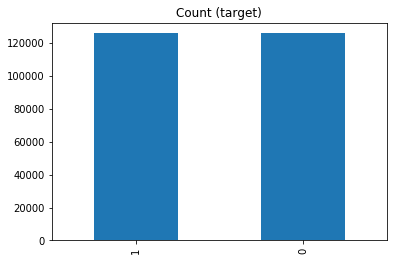

In [0]:
upsampled.target.value_counts().plot(kind='bar', title='Count (target)');

In [0]:
#Spliting the dataset to train (x) and target (y) after resampling
t = upsampled['target']
f = upsampled.drop(['target'], axis=1)

In [0]:
#Split the data
x_train, x_test, y_train, y_test = train_test_split(f, t,  test_size = .3, random_state = 0 )

In [0]:
x_train.shape

(176422, 200)

In [0]:
y_train.shape

(176422,)

In [0]:
x_train.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
19361,0.138809,1.232291,0.333376,0.440202,0.515891,1.654713,0.146262,-1.248469,-0.981857,0.015516,0.012082,-1.343079,-1.175835,-1.708070,0.566436,0.475271,-0.571110,0.956788,-1.406435,-0.740079,1.516328,-2.438916,-0.667508,-0.374156,0.994749,-0.632133,-0.990641,-0.451393,1.391586,0.685348,-1.026425,0.059797,-0.650552,-0.525216,-0.820604,-1.080133,0.056658,0.527532,-0.073671,0.463288,...,-1.798803,0.149159,0.768313,0.895457,-0.726651,0.192857,-0.625765,-0.562573,-0.511988,0.308015,-0.060104,-0.870143,-1.319737,-0.243207,0.352001,0.427496,-1.034761,1.635622,0.574089,1.761038,0.371637,-0.159942,0.929634,0.600998,-0.398935,-0.897608,0.892523,0.673327,-1.767045,1.159250,-1.663287,1.247027,0.080195,-0.190123,1.509723,1.833948,-1.575866,-0.824261,-0.389553,1.089418
91002,-1.748368,-1.603907,0.428723,1.082883,1.543156,0.032317,2.082899,-0.159783,-0.716571,-0.194513,0.669770,-1.845455,-1.043771,-0.124028,-0.483342,-1.780198,-0.506474,0.956714,-0.208794,0.879907,0.492867,-0.189041,-2.167043,-1.062912,-0.556359,-0.810745,-0.856518,0.445890,-0.008399,0.512217,1.424656,-0.220820,1.703975,0.486997,0.671421,-1.548784,1.849207,2.306550,-0.472793,0.165439,...,1.063994,0.046837,0.688361,0.883370,1.248185,0.008648,0.729448,-0.797941,-0.389354,0.049242,0.286909,2.110057,-0.097381,0.266241,-1.901121,-0.994071,-0.530790,1.525043,1.045732,-2.049892,0.882544,-0.458442,0.563769,1.254217,-2.182659,-0.241609,-0.301708,0.555898,-0.784586,0.236523,-1.568570,0.959159,-0.284316,0.729562,-0.432254,-0.937625,-0.573273,0.976041,-1.470844,-0.027703
121782,-0.149345,-1.834226,0.608851,0.364687,-0.221319,-1.100141,-0.012057,0.641810,-0.645516,-0.170466,-1.867615,-0.570112,0.577833,-0.450915,1.997415,0.755565,1.358808,-0.270606,0.658471,1.057781,0.657377,-1.526483,-2.225119,-0.716920,0.241949,-0.193658,0.959819,1.291786,0.268994,-0.787777,0.750597,-0.600424,-0.851184,0.809903,-0.554547,-0.339933,-0.408090,-0.378090,-0.514533,-1.153022,...,1.181730,-1.508653,1.281764,-1.639985,0.428564,1.340211,-0.518105,0.524898,-0.391994,0.523207,-2.731911,-0.411031,-0.240288,0.238151,-2.389070,-0.922429,-1.293894,-0.197244,-1.669719,0.206598,1.059537,0.337849,0.109991,-0.880014,-1.861365,-2.148488,0.429415,-0.910639,0.433258,1.999117,-0.977506,1.305837,0.543866,-0.577821,-1.425156,0.219599,-1.360607,1.470712,0.239221,-0.167433
128227,-2.032278,0.933899,0.618962,0.690384,-1.376422,0.908978,0.216421,-1.920106,-1.264967,0.744546,0.342108,-1.236233,1.128189,0.213011,-0.017530,0.706745,-0.944807,0.235070,-0.014713,0.369420,1.223198,0.410212,-0.103910,0.434169,1.785486,1.709438,1.283921,0.129820,0.200571,-0.097049,0.939319,-0.097295,-0.944970,1.187015,-0.991944,-0.781864,-0.190204,-0.967274,-1.764062,0.989508,...,-0.189628,-1.341174,-1.867766,-2.002487,1.439179,-1.120992,-0.569771,-1.283886,-1.418852,-0.978000,-0.268326,-0.323564,-1.847812,-0.521185,-0.114144,-0.821467,-0.315563,-0.094387,-1.351739,-1.028044,-1.744523,-0.056360,-0.703505,-0.833801,-1.593407,0.521160,1.084607,-1.362099,-0.099953,0.521463,1.402804,-0.686380,-0.568674,-0.462942,-0.396754,0.426544,0.813802,-0.371147,-0.283108,0.744946
46411,0.770280,0.408841,0.574469,-1.182260,-0.000698,0.497049,-1.817724,-0.093137,-1.520171,-0.371183,-0.219049,0.470935,-0.913811,-2.268386,-1.716091,1.728579,-0.464400,0.223137,-0.372638,2.343629,0.226132,-0.090756,-2.141550,0.798760,-1.826892,-0.008391,-0.206033,-0.395215,0.780505,1.262121,0.893682,0.6476

In [0]:
#Rank the features and select the important ones
sel=SelectFromModel(RandomForestClassifier(n_estimators=60,max_depth=30))
sel.fit(x_train,y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                 class_weight=None,
                                                 criterion='gini', max_depth=30,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=60, n_jobs=None,
                                                 oob_score=False,
                                                 random_state=None, verbose=0,
                                                 warm_

In [0]:
#Which features are important 
sel.get_support()

array([ True,  True,  True, False, False, False,  True, False, False,
        True, False, False,  True,  True, False, False, False, False,
        True, False, False,  True,  True, False, False, False,  True,
       False, False, False, False, False, False,  True,  True, False,
       False, False, False, False,  True, False, False, False,  True,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False,  True, False,  True, False,  True,
        True, False, False, False, False, False, False, False, False,
       False,  True,  True, False,  True,  True, False, False, False,
        True, False, False, False, False, False, False, False, False,
        True,  True,  True, False, False, False, False,  True, False,
       False, False, False, False,  True,  True,  True, False, False,
       False,  True,

In [0]:
#make list and count the selected features
selected_feat=x_train.columns[(sel.get_support())]
len(selected_feat)

55

In [0]:
#The name of the selected features
print(selected_feat)

Index(['var_0', 'var_1', 'var_2', 'var_6', 'var_9', 'var_12', 'var_13',
       'var_18', 'var_21', 'var_22', 'var_26', 'var_33', 'var_34', 'var_40',
       'var_44', 'var_53', 'var_67', 'var_76', 'var_78', 'var_80', 'var_81',
       'var_91', 'var_92', 'var_94', 'var_95', 'var_99', 'var_108', 'var_109',
       'var_110', 'var_115', 'var_121', 'var_122', 'var_123', 'var_127',
       'var_133', 'var_139', 'var_146', 'var_148', 'var_149', 'var_154',
       'var_164', 'var_165', 'var_166', 'var_169', 'var_170', 'var_172',
       'var_173', 'var_174', 'var_177', 'var_179', 'var_184', 'var_190',
       'var_191', 'var_192', 'var_198'],
      dtype='object')


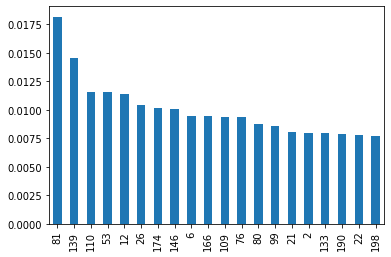

In [0]:
#Ploting the distribution of importance top 20
feat_importances=pd.Series(sel.estimator_.feature_importances_)
feat_importances.nlargest(20).plot(kind='bar')

In [0]:
importances_df = pd.DataFrame(sel.estimator_.feature_importances_, columns=['Feature_Importance'],
                             index=x_train.columns)
importances_df.sort_values(by=['Feature_Importance'], ascending=False, inplace=True)
importances_df

,Feature_Importance
var_81,0.018157
var_139,0.014559
var_110,0.011545
var_53,0.011519
var_12,0.011395
...,...
var_60,0.003672
var_126,0.003668
var_7,0.003638
var_68,0.003614


In [0]:
#Selecting the important features
features_x_new=f[selected_feat]
features_x_new.head()

,var_0,var_1,var_2,var_6,var_9,var_12,var_13,var_18,var_21,var_22,var_26,var_33,var_34,var_40,var_44,var_53,var_67,var_76,var_78,var_80,var_81,var_91,var_92,var_94,var_95,var_99,var_108,var_109,var_110,var_115,var_121,var_122,var_123,var_127,var_133,var_139,var_146,var_148,var_149,var_154,var_164,var_165,var_166,var_169,var_170,var_172,var_173,var_174,var_177,var_179,var_184,var_190,var_191,var_192,var_198
32759,-0.255462,-1.092331,0.540238,2.230948,-0.449884,0.770931,-0.209296,1.746411,1.162675,-1.015127,-1.895255,-1.064325,-1.182486,0.323086,-0.448782,1.208931,-0.563132,0.139882,0.685540,0.868643,0.829887,-0.386801,-0.453050,0.841785,1.666245,0.462430,-1.174437,-0.331181,-0.062313,-0.523569,0.988216,-1.125321,0.636788,0.241163,0.797198,0.114280,1.176128,-1.095052,0.049221,0.782871,-1.037382,-1.081523,0.179789,1.555051,0.543813,1.728066,1.115711,-0.392491,-1.010516,-0.085619,-0.578979,1.252450,-0.968757,1.217491,0.469017
28335,0.205223,0.702691,1.059306,2.029703,-1.007262,2.083157,1.405180,0.632603,0.608905,0.549683,0.087254,-1.485766,0.184357,1.723046,-1.251011,1.305564,0.848825,0.776464,-0.881277,-1.102683,-0.875134,-0.993456,-0.604642,0.718162,-0.000412,-0.929913,-0.474809,0.928859,-0.810290,-1.082031,-0.519706,0.372396,0.344173,0.785643,-0.509503,-1.657794,0.987909,1.160058,-2.440113,0.004080,0.450002,0.507237,-1.665303,0.103108,0.628521,-0.709314,-0.489090,-0.224592,-1.064265,-1.030974,0.240691,-1.222664,0.853677,-1.396179,1.166905
137970,-1.175416,1.104317,-0.983681,2.769141,-0.688008,-0.549713,-0.133210,1.173860,1.223860,-0.572598,0.052739,-0.617041,0.744536,-2.635109,0.343925,1.029657,-1.041334,1.185719,-0.857905,1.228130,-1.190194,-1.752103,-0.603496,-0.006308,-0.812810,-1.266817,1.217276,0.940730,2.159674,0.425724,-0.336903,-0.102097,0.612143,-0.296368,1.119081,0.400500,0.511983,0.320667,0.599191,1.165807,-1.443464,-0.671962,-0.404495,1.257299,-0.863610,0.052674,0.155894,0.251741,-1.959282,-0.305702,0.091146,-1.588943,0.819310,-0.221817,-2.044552
40100,-0.150956,-1.302033,0.196604,-1.274801,0.221092,-0.061443,-1.570599,0.152456,1.669377,-0.475335,0.754287,-0.819664,-1.407924,-0.094670,1.053541,2.315435,-0.056445,0.413327,0.409482,0.000949,2.502032,-0.362561,0.729156,-1.814774,0.129675,-0.796010,0.141239,0.271663,-1.654155,-0.125452,0.353771,-0.398761,-0.872924,-0.501074,-0.754176,-0.075327,-0.358206,0.544070,1.608107,0.897430,1.020216,0.604030,0.813844,0.556231,1.364270,-0.824622,-0.366894,1.237825,-1.267621,0.344685,-1.672821,-0.362055,-0.344928,-0.260710,0.116934
161919,-0.911867,-0.284610,-1.464542,-0.477898,-1.092521,0.313704,-1.068953,-0.630619,0.126995,-1.592208,-0.178695,1.228081,0.540885,0.640531,1.259823,0.163885,-0.281615,0.996208,0.035270,-0.172205,1.479011,1.675564,-0.699047,1.335880,0.089586,-0.562458,1.327159,-0.638734,0.889653,-0.323519,-0.082005,-1.171195,0.102686,-0.541805,1.413541,-1.513136,0.082585,0.370368,0.203702,1.109878,-1.135481,-2.029341,-1.017992,-0.575224,-1.506243,1.722325,-2.178176,1.007373,1.477951,-0.596990,-0.064902,-0.836122,0.012004,-0.278026,2.048790


In [0]:
features_x_new.shape

(252032, 55)

In [0]:
#Split the data again after selecting the features
x_NewTrain, x_NewTest, y_NewTrain, y_NewTest = train_test_split(features_x_new, t,  test_size = .3, random_state = 0 )

In [0]:
x_NewTrain.shape , y_NewTrain.shape

((176422, 55), (176422,))

##Using Scikit-learn to do the predictions
**First Support Vector Machine (SVM)**

In [0]:
acc = []; pre = [] ; rec = [] ; f = [] ; ro = []

In [0]:
#1) with linear kernel
clf1_1 = svm.LinearSVC()
clf1_1.fit(x_NewTrain, y_NewTrain)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [0]:
y_pred1_1 = clf1_1.predict(x_NewTest)
#evaluaion 
Accuracy1_1 = metrics.accuracy_score(y_NewTest, y_pred1_1)
Precision1_1 = metrics.precision_score(y_NewTest , y_pred1_1)
Recall1_1 = metrics.recall_score(y_NewTest , y_pred1_1)
F1_Score1_1 = metrics.f1_score(y_NewTest , y_pred1_1)
Roc_1 = metrics.roc_auc_score(y_NewTest, y_pred1_1)

print(" Support Vectore Machine with linear kernel")
print ("Accuracy = " ,  Accuracy1_1 )
print ("Precision = " , Precision1_1)
print ("Recall = " , Recall1_1 )
print ("F1_Score = " , F1_Score1_1)
print ("ROC_Curve = " , Roc_1)

ro.append(Roc_1)
acc.append(Accuracy1_1)
pre.append(Precision1_1) 
rec.append(Recall1_1)
f.append(F1_Score1_1)

 Support Vectore Machine with linear kernel
Accuracy =  0.7340695675175242
Precision =  0.7357550237194179
Recall =  0.7303632371226753
F1_Score =  0.7330492160220922
ROC_Curve =  0.7340689793822628


In [0]:
#2) with poly kernel 
params1_2 = [ {'C': [0.01, 0.1], 'kernel': ['poly'],
                'degree': [1, 2],
                'gamma': [0.1, 0.2]}]
clf1_2 = GridSearchCV(estimator = svm.SVC(),
                         param_grid = params1_2,
                         scoring = 'neg_mean_squared_error',verbose=2,cv=2)
                         
clf1_2.fit(x_NewTrain, y_NewTrain)


Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] C=0.01, degree=1, gamma=0.1, kernel=poly ........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ......... C=0.01, degree=1, gamma=0.1, kernel=poly, total=16.5min
[CV] C=0.01, degree=1, gamma=0.1, kernel=poly ........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 16.5min remaining:    0.0s


[CV] ......... C=0.01, degree=1, gamma=0.1, kernel=poly, total=15.7min
[CV] C=0.01, degree=1, gamma=0.2, kernel=poly ........................
[CV] ......... C=0.01, degree=1, gamma=0.2, kernel=poly, total=15.3min
[CV] C=0.01, degree=1, gamma=0.2, kernel=poly ........................
[CV] ......... C=0.01, degree=1, gamma=0.2, kernel=poly, total=15.4min
[CV] C=0.01, degree=2, gamma=0.1, kernel=poly ........................
[CV] ......... C=0.01, degree=2, gamma=0.1, kernel=poly, total=21.9min
[CV] C=0.01, degree=2, gamma=0.1, kernel=poly ........................
[CV] ......... C=0.01, degree=2, gamma=0.1, kernel=poly, total=20.3min
[CV] C=0.01, degree=2, gamma=0.2, kernel=poly ........................
[CV] ......... C=0.01, degree=2, gamma=0.2, kernel=poly, total=27.5min
[CV] C=0.01, degree=2, gamma=0.2, kernel=poly ........................
[CV] ......... C=0.01, degree=2, gamma=0.2, kernel=poly, total=24.3min
[CV] C=0.1, degree=1, gamma=0.1, kernel=poly .........................
[CV] .

[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed: 516.7min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [0.01, 0.1], 'degree': [1, 2],
                          'gamma': [0.1, 0.2], 'kernel': ['poly']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=2)

In [0]:
y_pred1_2 = clf1_2.predict(x_NewTest)
best_params1_2 = clf1_2.best_params_ 
print("By GridSearch, the best parameters are: ") 
print(best_params1_2)
#evaluaion 
Accuracy1_2 = metrics.accuracy_score(y_NewTest, y_pred1_2)
Precision1_2 = metrics.precision_score(y_NewTest , y_pred1_2)
Recall1_2 = metrics.recall_score(y_NewTest , y_pred1_2)
F1_Score1_2 = metrics.f1_score(y_NewTest , y_pred1_2)
Roc_2 = metrics.roc_auc_score(y_NewTest, y_pred1_2)


print(" Support Vectore Machine with poly kernel ")
print ("Accuracy = " ,  Accuracy1_2 )
print ("Precision = " , Precision1_2)
print ("Recall = " , Recall1_2 )
print ("F1_Score = " , F1_Score1_2)
print ("ROC_Curve = " , Roc_2)
ro.append(Roc_2)
acc.append(Accuracy1_2)
pre.append(Precision1_2) 
rec.append(Recall1_2)
f.append(F1_Score1_2)

By GridSearch, the best parameters are: 
{'C': 0.01, 'degree': 1, 'gamma': 0.1, 'kernel': 'poly'}
 Support Vectore Machine with poly kernel 
Accuracy =  0.7336727946038883
Precision =  0.7389210540555164
Recall =  0.722558797851795
F1_Score =  0.7306483326868286
ROC_Curve =  0.7336710309906407


TypeError: ignored

In [0]:
#3) with Radial basis function (RBF) kernel

params1_3 = [ {'C': [0.01, 0.1], 'kernel': ['rbf'],
              'gamma': [0.1, 0.2]}]
clf1_3 = GridSearchCV(estimator = svm.SVC(),
                         param_grid = params1_3,
                         scoring = 'neg_mean_squared_error',verbose=2,cv=2)
                        
clf1_3.fit(x_NewTrain, y_NewTrain)


Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... C=0.01, gamma=0.1, kernel=rbf, total=28.1min
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 28.1min remaining:    0.0s


[CV] .................... C=0.01, gamma=0.1, kernel=rbf, total=29.2min
[CV] C=0.01, gamma=0.2, kernel=rbf ...................................
[CV] .................... C=0.01, gamma=0.2, kernel=rbf, total=32.0min
[CV] C=0.01, gamma=0.2, kernel=rbf ...................................
[CV] .................... C=0.01, gamma=0.2, kernel=rbf, total=31.8min
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=28.9min
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=28.9min
[CV] C=0.1, gamma=0.2, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.2, kernel=rbf, total=31.7min
[CV] C=0.1, gamma=0.2, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.2, kernel=rbf, total=31.7min


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 242.3min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [0.01, 0.1], 'gamma': [0.1, 0.2],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=2)

In [0]:
y_pred1_3 = clf1_3.predict(x_NewTest)

best_params1_3 = clf1_3.best_params_ 
print("By GridSearch, the best parameters are: ") 
print(best_params1_3)
#evaluaion 
Accuracy1_3 = metrics.accuracy_score(y_NewTest, y_pred1_3)
Precision1_3 = metrics.precision_score(y_NewTest , y_pred1_3)
Recall1_3 = metrics.recall_score(y_NewTest , y_pred1_3)
F1_Score1_3 = metrics.f1_score(y_NewTest , y_pred1_3)
Roc_3 = metrics.roc_auc_score(y_NewTest, y_pred1_3)

print(" Support Vectore Machine with Radial basis function (RFB) kernel ")
print ("Accuracy = " ,  Accuracy1_3 )
print ("Precision = " , Precision1_3)
print ("Recall = " , Recall1_3 )
print ("F1_Score = " , F1_Score1_3)
print ("ROC_Curve = " , Roc_3)
ro.append(Roc_3)
acc.append(Accuracy1_3)
pre.append(Precision1_3) 
rec.append(Recall1_3)
f.append(F1_Score1_3)

By GridSearch, the best parameters are: 
{'C': 0.1, 'gamma': 0.2, 'kernel': 'rbf'}
 Support Vectore Machine with Radial basis function (RFB) kernel 
Accuracy =  0.79944451792091
Precision =  1.0
Recall =  0.5988253657504167
F1_Score =  0.7490816427838634
ROC_Curve =  0.7994126828752084


'ro.append(Roc_3)\nacc.append(Accuracy1_3)\npre.append(Precision1_3) \nrec.append(Recall1_3)\nf.append(F1_Score1_3)'

**Second Naive Bayes (NB)**

In [0]:
clf2 = GaussianNB()
clf2.fit(x_NewTrain, y_NewTrain)

GaussianNB(priors=None, var_smoothing=1e-09)

In [0]:
y_pred2 = clf2.predict(x_NewTest)
#evaluaion 
Accuracy2 = metrics.accuracy_score(y_NewTest, y_pred2)
Precision2 = metrics.precision_score(y_NewTest , y_pred2)
Recall2 = metrics.recall_score(y_NewTest , y_pred2)
F1_Score2 = metrics.f1_score(y_NewTest , y_pred2)
Roc2 = metrics.roc_auc_score(y_NewTest, y_pred2)

print(" Gaussian Naive Bayes")
print ("Accuracy = " ,  Accuracy2 )
print ("Precision = " , Precision2 )
print ("Recall = " , Recall2 )
print ("F1_Score = " , F1_Score2)
print ("ROC_Curve = " , Roc2)

ro.append(Roc2)
acc.append(Accuracy2)
pre.append(Precision2) 
rec.append(Recall2)
f.append(F1_Score2)

 Gaussian Naive Bayes
Accuracy =  0.7614336727946038
Precision =  0.7674815235929505
Recall =  0.7500198417947564
F1_Score =  0.7586502180952126
ROC_Curve =  0.7614318616024641


**Third Logistic Regression**

In [0]:
clf3 = LogisticRegression()
clf3.fit(x_NewTrain, y_NewTrain)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_pred3 = clf3.predict(x_NewTest)
#evaluaion 
Accuracy3 = metrics.accuracy_score(y_NewTest, y_pred3)
Precision3 = metrics.precision_score(y_NewTest , y_pred3)
Recall3 = metrics.recall_score(y_NewTest , y_pred3)
F1_Score3 = metrics.f1_score(y_NewTest , y_pred3)
Roc3 = metrics.roc_auc_score(y_NewTest, y_pred3)

print("Logistic regression")
print ("Accuracy = " ,  Accuracy3 )
print ("Precision = " , Precision3 )
print ("Recall = " , Recall3 )
print ("F1_Score = " , F1_Score3)
print ("ROC_Curve = " , Roc3)

ro.append(Roc3)
acc.append(Accuracy3)
pre.append(Precision3) 
rec.append(Recall3)
f.append(F1_Score3)

Logistic regression
Accuracy =  0.734082793281312
Precision =  0.7352980290980663
Recall =  0.7313685547236699
F1_Score =  0.733328028012096
ROC_Curve =  0.7340823625751327


**Forth Decision tree**

In [0]:
#1 ) Dicision tree with all defult hyperparameter
clf4_1 = DecisionTreeClassifier()
clf4_1.fit(x_NewTrain, y_NewTrain)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [0]:
y_pred4_1 = clf4_1.predict(x_NewTest)
#evaluaion 
Accuracy4_1 = metrics.accuracy_score(y_NewTest, y_pred4_1)
Precision4_1 = metrics.precision_score(y_NewTest , y_pred4_1)
Recall4_1 = metrics.recall_score(y_NewTest , y_pred4_1)
F1_Score4_1 = metrics.f1_score(y_NewTest , y_pred4_1)
Roc4_1 = metrics.roc_auc_score(y_NewTest, y_pred4_1)

print("Dicision tree with all defult hyperparameter")
print ("Accuracy = " ,  Accuracy4_1 )
print ("Precision = " , Precision4_1 )
print ("Recall = " , Recall4_1 )
print ("F1_Score = " , F1_Score4_1)
print ("ROC_Curve = " , Roc4_1)

ro.append(Roc4_1)
acc.append(Accuracy4_1)
pre.append(Precision4_1) 
rec.append(Recall4_1)
f.append(F1_Score4_1)

Dicision tree with all defult hyperparameter
Accuracy =  0.9391879381034255
Precision =  0.89210383352623
Recall =  0.999206328209741
F1_Score =  0.9426225416791454
ROC_Curve =  0.9391974620604918


In [0]:
#2)  Dicision tree with criterion = entropy and  max_depth = 20 
clf4_2 = DecisionTreeClassifier(criterion='entropy',max_depth = 20)
clf4_2.fit(x_NewTrain, y_NewTrain)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=20,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [0]:
y_pred4_2 = clf4_2.predict(x_NewTest)
#evaluaion 
Accuracy4_2 = metrics.accuracy_score(y_NewTest, y_pred4_2)
Precision4_2 = metrics.precision_score(y_NewTest , y_pred4_2)
Recall4_2 = metrics.recall_score(y_NewTest , y_pred4_2)
F1_Score4_2 = metrics.f1_score(y_NewTest , y_pred4_2)
Roc4_2 = metrics.roc_auc_score(y_NewTest, y_pred4_2)

print("Dicision tree with criterion = entropy and  max_depth = 20")
print ("Accuracy = " ,  Accuracy4_2 )
print ("Precision = " , Precision4_2 )
print ("Recall = " , Recall4_2 )
print ("F1_Score = " , F1_Score4_2)
print ("ROC_Curve = " , Roc4_2)

ro.append(Roc4_2)
acc.append(Accuracy4_2)
pre.append(Precision4_2) 
rec.append(Recall4_2)
f.append(F1_Score4_2)

Dicision tree with criterion = entropy and  max_depth = 20
Accuracy =  0.8684830048935326
Precision =  0.8429151791210144
Recall =  0.9057117913172306
F1_Score =  0.8731859106792154
ROC_Curve =  0.8684889125055646


In [0]:
#3)  Dicision tree with max_depth = 18 
clf4_3 = DecisionTreeClassifier( max_depth = 18)
clf4_3.fit(x_NewTrain, y_NewTrain)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=18,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [0]:
y_pred4_3 = clf4_3.predict(x_NewTest)
#evaluaion 
Accuracy4_3 = metrics.accuracy_score(y_NewTest, y_pred4_3)
Precision4_3 = metrics.precision_score(y_NewTest , y_pred4_3)
Recall4_3 = metrics.recall_score(y_NewTest , y_pred4_3)
F1_Score4_3 = metrics.f1_score(y_NewTest , y_pred4_3)
Roc4_3 = metrics.roc_auc_score(y_NewTest, y_pred4_3)

print("Dicision tree with max_depth = 18 ")
print ("Accuracy = " ,  Accuracy4_3 )
print ("Precision = " , Precision4_3 )
print ("Recall = " , Recall4_3 )
print ("F1_Score = " , F1_Score4_3 )
print ("ROC_Curve = " , Roc4_3)

ro.append(Roc4_3)
acc.append(Accuracy4_3)
pre.append(Precision4_3) 
rec.append(Recall4_3)
f.append(F1_Score4_3)

Dicision tree with max_depth = 18 
Accuracy =  0.8438301811929639
Precision =  0.8337913852002158
Recall =  0.8588057885129237
F1_Score =  0.8461137465464212
ROC_Curve =  0.8438325575819492


**Fifth Random Forest**

In [0]:
#Random Forest with best (criterion , Max feature , Max depth , Number of trees)
#Determine the best using GridSearch
params5 = [{'criterion': ['gini' , 'entropy'] ,
           'max_features': ['auto', 'log2'],
           'max_depth': [15, 25],
           'n_estimators': [100, 150] }]
clf5 = GridSearchCV(estimator = RandomForestClassifier(),
                            param_grid = params5,
                            scoring = 'neg_mean_squared_error',verbose=2,cv=2)
                            
clf5.fit(x_NewTrain, y_NewTrain) 

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] criterion=gini, max_depth=15, max_features=auto, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=gini, max_depth=15, max_features=auto, n_estimators=100, total= 1.1min
[CV] criterion=gini, max_depth=15, max_features=auto, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV]  criterion=gini, max_depth=15, max_features=auto, n_estimators=100, total= 1.1min
[CV] criterion=gini, max_depth=15, max_features=auto, n_estimators=150 
[CV]  criterion=gini, max_depth=15, max_features=auto, n_estimators=150, total= 1.7min
[CV] criterion=gini, max_depth=15, max_features=auto, n_estimators=150 
[CV]  criterion=gini, max_depth=15, max_features=auto, n_estimators=150, total= 1.7min
[CV] criterion=gini, max_depth=15, max_features=log2, n_estimators=100 
[CV]  criterion=gini, max_depth=15, max_features=log2, n_estimators=100, total=  50.3s
[CV] criterion=gini, max_depth=15, max_features=log2, n_estimators=100 
[CV]  criterion=gini, max_depth=15, max_features=log2, n_estimators=100, total=  50.4s
[CV] criterion=gini, max_depth=15, max_features=log2, n_estimators=150 
[CV]  criterion=gini, max_depth=15, max_features=log2, n_estimators=150, total= 1.3min
[CV] criterion=gini, max_depth=15, max_features=log2, n_estimators=150 
[CV]  criterion=gini, max_depth=15, max_featur

[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed: 57.8min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [0]:
y_pred5 = clf5.predict(x_NewTest)

best_params5 = clf5.best_params_ #Determine which parameters used by the model
print("By GridSearch, the best parameters are: ") 
print(best_params5)
#evaluaion 
Accuracy5 = metrics.accuracy_score(y_NewTest, y_pred5)
Precision5 = metrics.precision_score(y_NewTest , y_pred5)
Recall5 = metrics.recall_score(y_NewTest , y_pred5)
F1_Score5 = metrics.f1_score(y_NewTest , y_pred5)
Roc5 = metrics.roc_auc_score(y_NewTest, y_pred5)

print(" \nRandom Forest with best (criterion , Max feature , Max depth , Number of trees) ")
print ("Accuracy = " ,  Accuracy5 )
print ("Precision = " , Precision5 )
print ("Recall = " , Recall5 )
print ("F1_Score = " , F1_Score5 )
print ("ROC_Curve = " , Roc5)

ro.append(Roc5)
acc.append(Accuracy5)
pre.append(Precision5) 
rec.append(Recall5)
f.append(F1_Score5)

By GridSearch, the best parameters are: 
{'criterion': 'entropy', 'max_depth': 25, 'max_features': 'log2', 'n_estimators': 150}
 
Random Forest with best (criterion , Max feature , Max depth , Number of trees) 
Accuracy =  0.9984129083454569
Precision =  0.9991257120148364
Recall =  0.9976983518082488
F1_Score =  0.9984115217621519
ROC_Curve =  0.9984127949567811


**Sixth Gradient Boosting Classifier**

In [0]:
#Gradient Boosting Classifier (GridSearchCV for Hyperparameter Tuning)
params6 = [{'subsample': [1.0 , 0.5] ,
           'max_depth': [3, 10],
           'learning_rate': [0.1,0.05],
           'n_estimators': [10, 60] }]
clf6 = GridSearchCV(GradientBoostingClassifier(n_iter_no_change=5, tol=0.01),
                            param_grid = params6,
                            scoring = 'neg_mean_squared_error',verbose=2,cv=2)
clf6.fit(x_NewTrain, y_NewTrain) #train the model using trainning dataSets


Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] learning_rate=0.1, max_depth=3, n_estimators=10, subsample=1.0 ..


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.1, max_depth=3, n_estimators=10, subsample=1.0, total=   5.4s
[CV] learning_rate=0.1, max_depth=3, n_estimators=10, subsample=1.0 ..


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=3, n_estimators=10, subsample=1.0, total=   5.3s
[CV] learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.5 ..
[CV]  learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.5, total=   4.1s
[CV] learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.5 ..
[CV]  learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.5, total=   4.1s
[CV] learning_rate=0.1, max_depth=3, n_estimators=60, subsample=1.0 ..
[CV]  learning_rate=0.1, max_depth=3, n_estimators=60, subsample=1.0, total=  28.6s
[CV] learning_rate=0.1, max_depth=3, n_estimators=60, subsample=1.0 ..
[CV]  learning_rate=0.1, max_depth=3, n_estimators=60, subsample=1.0, total=  28.6s
[CV] learning_rate=0.1, max_depth=3, n_estimators=60, subsample=0.5 ..
[CV]  learning_rate=0.1, max_depth=3, n_estimators=60, subsample=0.5, total=  21.5s
[CV] learning_rate=0.1, max_depth=3, n_estimators=60, subsample=0.5 ..
[CV]  learning_rate=0.1, max_depth=3, n_estimators=60, subsample=0.5, 

[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed: 110.4min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=5,
                                                  presort='au

In [0]:
y_pred6= clf6.predict(x_NewTest)

best_params6 = clf6.best_params_  #Determine which parameters used by the model 
print("By GridSearch, the best parameters are: ") 
print(best_params6)
#evaluaion 
Accuracy6 = metrics.accuracy_score(y_NewTest, y_pred6)
Precision6 = metrics.precision_score(y_NewTest , y_pred6)
Recall6 = metrics.recall_score(y_NewTest , y_pred6)
F1_Score6 = metrics.f1_score(y_NewTest , y_pred6)
Roc6 = metrics.roc_auc_score(y_NewTest, y_pred6)

print(" \nGradient Boosting Classifier (GridSearchCV for Hyperparameter Tuning) ")
print ("Accuracy = " ,  Accuracy6 )
print ("Precision = " , Precision6 )
print ("Recall = " , Recall6 )
print ("F1_Score = " , F1_Score6 )
print ("ROC_Curve = " , Roc6)

ro.append(Roc6)
acc.append(Accuracy6)
pre.append(Precision6) 
rec.append(Recall6)
f.append(F1_Score6)

By GridSearch, the best parameters are: 
{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 60, 'subsample': 1.0}
 
Gradient Boosting Classifier (GridSearchCV for Hyperparameter Tuning) 
Accuracy =  0.9336331173125249
Precision =  0.9278721904612734
Recall =  0.940342337098865
F1_Score =  0.9340656452842089
ROC_Curve =  0.9336341819582289


**Seventh BaggingClassifier**

In [0]:
#1) BaggingClassifier with Naïve bayes
params7_1 = [{'n_estimators': [10, 50, 90 ],
             'oob_score': ['True' , 'False'] }]
clf7_1 = GridSearchCV(estimator = BaggingClassifier(base_estimator=clf2) ,
                            param_grid = params7_1,
                            scoring = 'neg_mean_squared_error')
                            
clf7_1.fit(x_NewTrain, y_NewTrain) 

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/bagging.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/bagging.py:616: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/bagging.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/bagging.py:616

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=BaggingClassifier(base_estimator=GaussianNB(priors=None,
                                                                   var_smoothing=1e-09),
                                         bootstrap=True,
                                         bootstrap_features=False,
                                         max_features=1.0, max_samples=1.0,
                                         n_estimators=10, n_jobs=None,
                                         oob_score=False, random_state=None,
                                         verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'n_estimators': [10, 50, 90],
                          'oob_score': ['True', 'False']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [0]:
y_pred7_1 = clf7_1.predict(x_NewTest)

best_params7_1= clf7_1.best_params_ #Determine which parameters used by the model
print("By GridSearch, the best parameters are: ") 
print(best_params7_1)
#evaluaion 
Accuracy7_1 = metrics.accuracy_score(y_NewTest, y_pred7_1)
Precision7_1 = metrics.precision_score(y_NewTest , y_pred7_1)
Recall7_1 = metrics.recall_score(y_NewTest , y_pred7_1)
F1_Score7_1 = metrics.f1_score(y_NewTest , y_pred7_1)
Roc7_1 = metrics.roc_auc_score(y_NewTest, y_pred7_1)

print(" \nBaggingClassifier with Naïve bayes ")
print ("Accuracy = " ,  Accuracy7_1)
print ("Precision = " , Precision7_1)
print ("Recall = " , Recall7_1)
print ("F1_Score = " , F1_Score7_1)
print ("ROC_Curve = " , Roc7_1)

ro.append(Roc7_1)
acc.append(Accuracy7_1)
pre.append(Precision7_1) 
rec.append(Recall7_1)
f.append(F1_Score7_1)

By GridSearch, the best parameters are: 
{'n_estimators': 10, 'oob_score': 'False'}
 
BaggingClassifier with Naïve bayes 
Accuracy =  0.7616188334876339
Precision =  0.7677870162229504
Recall =  0.7499933860684145
F1_Score =  0.7587858997350179
ROC_Curve =  0.7616169887153582


In [0]:
#2)  BaggingClassifier with decision trees
params7_2 = [{'base_estimator': [clf4_1, clf4_2, clf4_3] }]
clf7_2 = GridSearchCV(estimator = BaggingClassifier() ,
                            param_grid = params7_2,
                            scoring = 'neg_mean_squared_error')
                             
clf7_2.fit(x_NewTrain, y_NewTrain) 

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=BaggingClassifier(base_estimator=None, bootstrap=True,
                                         bootstrap_features=False,
                                         max_features=1.0, max_samples=1.0,
                                         n_estimators=10, n_jobs=None,
                                         oob_score=False, random_state=None,
                                         verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'base_estimator': [DecisionTreeClassifier(class_w...
                                             DecisionTreeClassifier(class_weight=None,
                                                                    criterion='gini',
                                                                    max_depth=18,
                                                                    max_features=None,
                                            

In [0]:
y_pred7_2 = clf7_2.predict(x_NewTest)

best_params7_2= clf7_2.best_params_ #Determine which parameters used by the model 
print("By GridSearch, the best parameters are: ")
print(best_params7_2)
#evaluaion 
Accuracy7_2 = metrics.accuracy_score(y_NewTest, y_pred7_2)
Precision7_2 = metrics.precision_score(y_NewTest , y_pred7_2)
Recall7_2 = metrics.recall_score(y_NewTest , y_pred7_2)
F1_Score7_2 = metrics.f1_score(y_NewTest , y_pred7_2)
Roc7_2 = metrics.roc_auc_score(y_NewTest, y_pred7_2)

print(" \nBaggingClassifier with decision trees ")
print ("Accuracy = " ,  Accuracy7_2)
print ("Precision = " , Precision7_2)
print ("Recall = " , Recall7_2)
print ("F1_Score = " , F1_Score7_2)
print ("ROC_Curve = " , Roc7_2)

ro.append(Roc7_2)
acc.append(Accuracy7_2)
pre.append(Precision7_2) 
rec.append(Recall7_2)
f.append(F1_Score7_2)

By GridSearch, the best parameters are: 
{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')}
 
BaggingClassifier with decision trees 
Accuracy =  0.9878852003703213
Precision =  0.9778457233177001
Recall =  0.99838620069314
F1_Score =  0.9880092156246728
ROC_Curve =  0.9878868667108555


**Eighth AdaBoosting**

In [0]:
#Adaptive Boosting Classifier (GridSearchCV for Hyperparameter Tuning)
params8 = [{'n_estimators': [10 ,20 , 50] ,
           'algorithm': ['SAMME' ,  'SAMME.R' ],
           'learning_rate': [0.1, 0.05, 0.02]}]
clf8 = GridSearchCV(estimator = AdaBoostClassifier(),
                            param_grid = params8,
                            scoring = 'neg_mean_squared_error')
                            
clf8.fit(x_NewTrain, y_NewTrain) 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='warn', n_jobs=None,
             param_grid=[{'algorithm': ['SAMME', 'SAMME.R'],
                          'learning_rate': [0.1, 0.05, 0.02],
                          'n_estimators': [10, 20, 50]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [0]:
y_pred8= clf8.predict(x_NewTest)

best_params8 = clf8.best_params_ #Determine which parameters used by the model
print("By GridSearch, the best parameters are: ")  
print(best_params8)
#evaluaion 
Accuracy8 = metrics.accuracy_score(y_NewTest, y_pred8)
Precision8 = metrics.precision_score(y_NewTest , y_pred8)
Recall8 = metrics.recall_score(y_NewTest , y_pred8)
F1_Score8 = metrics.f1_score(y_NewTest , y_pred8)
Roc8 = metrics.roc_auc_score(y_NewTest, y_pred8)

print(" \nAdaptive Boosting Classifier (GridSearchCV for Hyperparameter Tuning) ")
print ("Accuracy = " ,  Accuracy8)
print ("Precision = " , Precision8 )
print ("Recall = " , Recall8 )
print ("F1_Score = " , F1_Score8 )
print ("ROC_Curve = " , Roc8)

ro.append(Roc8)
acc.append(Accuracy8)
pre.append(Precision8) 
rec.append(Recall8)
f.append(F1_Score8)

By GridSearch, the best parameters are: 
{'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 50}
 
Adaptive Boosting Classifier (GridSearchCV for Hyperparameter Tuning) 
Accuracy =  0.6874884274566856
Precision =  0.7057439888488791
Recall =  0.6429535172888171
F1_Score =  0.6728871045891881
ROC_Curve =  0.6874813604798533


**Ninth Voting-Ensembling**

In [0]:
#Hard Voting-Ensembling  for 5 previous-methods
clf9 = VotingClassifier(estimators=[('bc', clf7_2), ('nb', clf2), ('lr', clf3), ('dt',clf4_3), ('rf', clf5) ], voting='hard')
clf9=clf9.fit(x_NewTrain, y_NewTrain) 

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] criterion=gini, max_depth=15, max_features=auto, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=gini, max_depth=15, max_features=auto, n_estimators=100, total= 1.2min
[CV] criterion=gini, max_depth=15, max_features=auto, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV]  criterion=gini, max_depth=15, max_features=auto, n_estimators=100, total= 1.2min
[CV] criterion=gini, max_depth=15, max_features=auto, n_estimators=150 
[CV]  criterion=gini, max_depth=15, max_features=auto, n_estimators=150, total= 1.7min
[CV] criterion=gini, max_depth=15, max_features=auto, n_estimators=150 
[CV]  criterion=gini, max_depth=15, max_features=auto, n_estimators=150, total= 1.7min
[CV] criterion=gini, max_depth=15, max_features=log2, n_estimators=100 
[CV]  criterion=gini, max_depth=15, max_features=log2, n_estimators=100, total=  51.3s
[CV] criterion=gini, max_depth=15, max_features=log2, n_estimators=100 
[CV]  criterion=gini, max_depth=15, max_features=log2, n_estimators=100, total=  51.2s
[CV] criterion=gini, max_depth=15, max_features=log2, n_estimators=150 
[CV]  criterion=gini, max_depth=15, max_features=log2, n_estimators=150, total= 1.3min
[CV] criterion=gini, max_depth=15, max_features=log2, n_estimators=150 
[CV]  criterion=gini, max_depth=15, max_featur

[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed: 59.1min finished


In [0]:
y_pred9 = clf9.predict(x_NewTest)

#evaluaion 
Accuracy9 = metrics.accuracy_score(y_NewTest, y_pred9)
Precision9 = metrics.precision_score(y_NewTest , y_pred9)
Recall9 = metrics.recall_score(y_NewTest , y_pred9)
F1_Score9 = metrics.f1_score(y_NewTest , y_pred9)
Roc9 = metrics.roc_auc_score(y_NewTest, y_pred9)


print(" \nHard Voting-Ensembling  ")
print ("Accuracy = " ,  Accuracy9)
print ("Precision = " , Precision9)
print ("Recall = " , Recall9)
print ("F1_Score = " , F1_Score9)
print ("ROC_Curve = " , Roc9)

ro.append(Roc9)
acc.append(Accuracy9)
pre.append(Precision9) 
rec.append(Recall9)
f.append(F1_Score9)

 
Hard Voting-Ensembling  
Accuracy =  0.9337918264779791
Precision =  0.9335748472909009
Recall =  0.934019418503135
F1_Score =  0.9337970799830723
ROC_Curve =  0.9337918625931877


##Ploting the comparision between classifiers methods

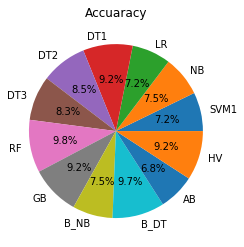

In [0]:
lab = ['SVM1', 'NB', 'LR', 'DT1', 'DT2', 'DT3', 'RF', 'GB', 'B_NB', 'B_DT','AB', 'HV' ]
plt.pie(acc,autopct='%.1f%%',labels=lab,)
plt.title('Accuaracy')
plt.show()

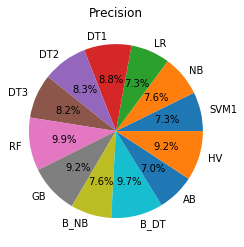

In [0]:
lab = ['SVM1', 'NB', 'LR', 'DT1', 'DT2', 'DT3', 'RF', 'GB', 'B_NB', 'B_DT','AB', 'HV' ]
plt.pie(pre,autopct='%.1f%%',labels=lab,)
plt.title('Precision')
plt.show()

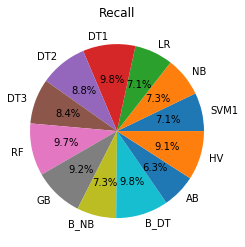

In [0]:
lab = ['SVM1', 'NB', 'LR', 'DT1', 'DT2', 'DT3', 'RF', 'GB', 'B_NB', 'B_DT','AB', 'HV' ]
plt.pie(rec,autopct='%.1f%%',labels=lab,)
plt.title('Recall')
plt.show()

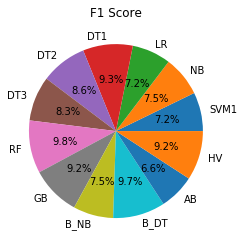

In [0]:
lab = ['SVM1', 'NB', 'LR', 'DT1', 'DT2', 'DT3', 'RF', 'GB', 'B_NB', 'B_DT','AB', 'HV' ]
plt.pie(f,autopct='%.1f%%',labels=lab,)
plt.title('F1 Score')
plt.show()

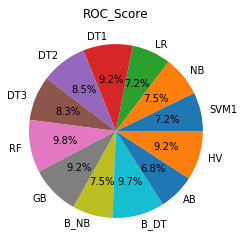

In [0]:
lab = ['SVM1', 'NB', 'LR', 'DT1', 'DT2', 'DT3', 'RF', 'GB', 'B_NB', 'B_DT','AB', 'HV' ]
plt.pie(ro,autopct='%.1f%%',labels=lab,)
plt.title('ROC_Score')
plt.show()

*********************************************************
The second method is **Resampling Techniques — Undersample majority class.**

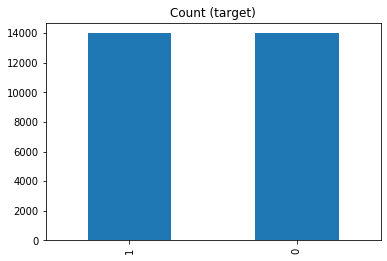

In [0]:
# concatenate our training data back together
z = pd.concat([x_train, y_train], axis=1)

# separate minority and majority classes
no_action = z[z.target==0]
action = z[z.target==1]

# upsample minority
no_action_downsampled = resample(no_action,
                          replace=False, # sample with replacement
                          n_samples=len(action)) # match number in majority class

# combine majority and upsampled minority
downsampled = pd.concat([no_action_downsampled, action])

downsampled.target.value_counts().plot(kind='bar', title='Count (target)');

In [0]:
# check new class counts
downsampled.target.value_counts()

1    13984
0    13984
Name: target, dtype: int64

In [0]:
#Spliting the dataset to train (x) and target (y) after resampling
t = downsampled['target']
f = downsampled.drop(['target'], axis=1)

#Split the data
x_train, x_test, y_train, y_test = train_test_split(f, t,  test_size = .3, random_state = 0 )

x_train.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
86709,-1.910471,0.884936,1.123375,0.339336,1.204369,-1.050175,1.325115,1.219271,-0.502085,0.311047,-0.735649,0.279770,0.416304,1.625462,-1.470885,-1.503061,0.785768,0.685716,-0.806245,1.511808,0.904372,1.566931,-1.084861,0.376472,-1.950447,-1.341329,0.713407,-0.695403,-0.491443,0.595629,0.024788,1.120733,-0.119102,-1.182502,-0.949663,0.107500,0.038613,-0.338708,0.488764,0.230003,...,0.610878,-0.967673,0.931809,-1.907618,0.147259,0.923644,1.966993,1.016498,-1.453205,-0.325113,0.566866,0.406690,1.164415,1.217024,0.742183,-0.904864,0.053845,0.347168,-0.170743,-0.449506,0.879883,-0.241583,0.103843,-0.742425,0.498744,-0.949226,1.100439,1.156882,1.247156,0.784997,-1.705898,-0.521757,1.847961,-0.319456,0.536087,1.141545,1.235923,1.381413,-1.026597,-0.184208
102029,2.203221,-0.921419,-2.095770,-0.574963,0.608797,-0.952276,1.061558,-0.472182,1.894044,-0.089255,0.473326,-0.732584,-1.542564,0.523193,0.670978,0.973437,0.452307,-0.388504,-1.567452,-1.619319,1.149171,0.684596,1.606794,-1.042224,-0.999355,-0.006640,2.285729,1.504359,-1.826708,-0.039708,-1.075024,-0.384440,-0.563027,0.084874,0.556210,1.061541,2.260974,-0.779740,-0.133967,-1.427204,...,0.127019,1.021886,0.974215,0.285921,1.134897,1.735420,0.045620,0.471936,-0.466173,-0.545990,-0.781275,-0.883568,0.245569,-2.079310,-1.367407,0.804619,0.847225,0.917143,0.927151,-1.529732,1.050033,0.796133,0.675255,0.415363,-0.342894,1.095321,-0.048115,-0.327928,0.332157,0.854952,-1.223827,0.818748,-0.620824,-1.108279,0.542371,-0.874310,0.051439,0.127213,0.592101,-1.190101
147754,0.649197,-0.638039,0.034651,-1.579214,0.058693,1.432489,0.335968,0.499390,0.987971,-1.272997,0.484433,-0.552675,-0.384501,-1.278694,-0.258110,1.801446,-0.248557,0.608026,-0.731838,1.032246,0.221112,0.528859,1.898898,0.632312,-0.498592,-1.020878,0.273502,1.607594,2.191086,1.011771,0.278279,-0.459722,-1.922780,-0.123047,-1.424356,-0.158411,0.611695,-0.410228,1.169782,1.243045,...,0.886194,-0.010978,-0.463717,0.724306,-0.654112,-0.549992,1.131143,-1.490260,0.623017,0.388678,-0.406824,0.411413,0.164270,1.044348,-0.384532,1.776211,2.108538,-0.858094,0.151538,-0.830827,-0.319380,0.489687,-0.538635,-0.538823,-0.671411,0.532313,-0.651297,1.239304,-0.791152,-2.239137,-1.126939,0.600540,0.258223,0.550956,0.422664,-0.656941,-1.097020,1.677521,-1.147722,0.309354
99242,0.074238,-0.262067,-2.182596,0.174213,-0.052942,-0.823296,1.200491,0.854679,0.925648,0.788349,1.763743,1.557257,-0.731762,-2.467825,-1.311092,-0.773908,1.777082,1.055170,0.912160,1.582625,-0.711049,0.829706,1.274801,0.515210,1.166964,-0.985505,-1.764762,-0.862757,0.785356,-0.650924,-0.868287,-0.589497,-0.744995,-2.195918,1.529599,1.545136,1.639205,-0.867839,-0.233222,1.280402,...,-0.320931,-0.356490,1.834592,0.793576,1.997319,-0.991219,-0.747761,1.232567,0.206755,0.339143,2.483216,0.828501,0.861907,1.566566,0.180612,-1.773627,-0.065520,-1.524878,1.251577,-0.010770,-0.224555,1.912064,0.573955,-0.194973,1.987509,1.262998,1.438929,1.147776,0.268196,0.713506,-0.114594,0.492081,0.041978,-1.874483,-1.396481,-0.423762,2.085409,0.139799,-0.415625,0.490165
159060,0.911298,1.021676,-2.029277,-0.031042,0.170759,0.331150,0.294426,-1.068864,0.882619,-0.663070,-0.026804,-0.385044,0.997177,0.997854,-1.982517,-0.830015,1.085876,-1.212626,0.072686,-1.466693,0.624448,-1.164025,0.166600,-0.237126,-1.282843,0.072860,0.263202,0.103502,0.557365,2.634097,0.130937,0.960771,-1.051314,-2.075496,-0.367513,-1.299

In [0]:
x_train.shape, y_train.shape

((19577, 200), (19577,))

Index(['var_0', 'var_1', 'var_2', 'var_6', 'var_9', 'var_12', 'var_13',
       'var_18', 'var_21', 'var_22', 'var_26', 'var_33', 'var_34', 'var_40',
       'var_44', 'var_53', 'var_67', 'var_75', 'var_76', 'var_78', 'var_80',
       'var_81', 'var_86', 'var_91', 'var_92', 'var_94', 'var_95', 'var_99',
       'var_108', 'var_109', 'var_110', 'var_112', 'var_115', 'var_118',
       'var_121', 'var_122', 'var_123', 'var_127', 'var_133', 'var_139',
       'var_146', 'var_147', 'var_148', 'var_149', 'var_154', 'var_164',
       'var_165', 'var_166', 'var_169', 'var_170', 'var_172', 'var_173',
       'var_174', 'var_177', 'var_179', 'var_180', 'var_184', 'var_188',
       'var_190', 'var_191', 'var_192', 'var_198'],
      dtype='object')


,Feature_Importance
var_81,0.015675
var_53,0.012075
var_110,0.011822
var_139,0.011700
var_12,0.010499
...,...
var_38,0.003527
var_136,0.003473
var_25,0.003450
var_100,0.003437


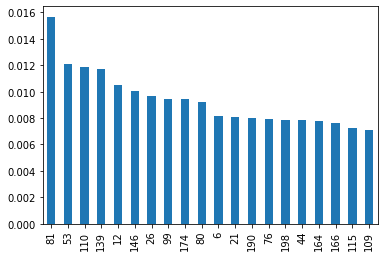

In [0]:
#Rank the features and select the important ones
sel=SelectFromModel(RandomForestClassifier(n_estimators=60,max_depth=30))
sel.fit(x_train,y_train)

#Which features are important 
sel.get_support()

#make list and count the selected features
selected_feat=x_train.columns[(sel.get_support())]
len(selected_feat)

#The name of the selected features
print(selected_feat)

#Ploting the distribution of importance top 20
feat_importances=pd.Series(sel.estimator_.feature_importances_)
feat_importances.nlargest(20).plot(kind='bar')

importances_df = pd.DataFrame(sel.estimator_.feature_importances_, columns=['Feature_Importance'],
                             index=x_train.columns)
importances_df.sort_values(by=['Feature_Importance'], ascending=False, inplace=True)
importances_df

In [0]:
len(selected_feat)

62

In [0]:
#Selecting the important features
features_x_new=f[selected_feat]
features_x_new.shape
features_x_new.head()

,var_0,var_1,var_2,var_6,var_9,var_12,var_13,var_18,var_21,var_22,var_26,var_33,var_34,var_40,var_44,var_53,var_67,var_75,var_76,var_78,var_80,var_81,var_86,var_91,var_92,var_94,var_95,var_99,var_108,var_109,var_110,var_112,var_115,var_118,var_121,var_122,var_123,var_127,var_133,var_139,var_146,var_147,var_148,var_149,var_154,var_164,var_165,var_166,var_169,var_170,var_172,var_173,var_174,var_177,var_179,var_180,var_184,var_188,var_190,var_191,var_192,var_198
126710,1.598788,-0.046241,-0.488658,0.370355,0.124255,0.382630,-0.223414,0.410998,-1.042303,-1.364501,-2.930681,0.325972,0.288306,1.924211,-2.105432,-0.335101,-0.267590,0.975139,1.418853,-0.346867,-0.371366,-1.043340,-0.041718,0.924124,-0.060049,0.438258,-1.695243,-1.088405,0.559730,1.675170,-0.940756,-1.416662,0.808241,0.349204,-2.292384,-0.702120,-0.668022,0.782424,-0.995921,-0.434727,-0.396477,0.893758,0.492863,0.522437,-0.137989,-0.434755,-0.666111,1.015368,1.174741,0.195489,0.101140,1.145711,-0.190583,0.756733,2.370017,2.324089,-1.258355,1.799076,-0.773335,0.524596,-0.492173,0.832458
120307,1.478856,0.461310,0.110155,-0.649487,1.806674,1.738000,-1.168230,1.066388,0.226293,0.597612,0.701941,-1.221185,1.051951,0.845863,-1.032141,-0.125490,0.973793,1.059495,-1.018775,1.192465,-0.553691,-0.308678,-0.854206,0.029209,0.943429,0.733660,0.095382,0.219429,1.237733,0.142617,0.061299,-1.074334,-1.637556,-1.805242,0.546782,1.754199,0.767674,-1.002528,1.154490,0.981343,-0.205877,-1.005091,-1.186422,-0.012098,1.630067,2.076710,-0.535482,-2.132459,-0.166222,0.781394,-0.113878,-0.256732,-1.622241,-1.323728,0.254473,-0.632634,-0.213804,-0.011731,0.935953,0.378628,0.251797,0.272998
187832,0.749590,0.822566,0.693482,0.960012,-1.546181,1.170281,-0.169766,-0.424718,0.557749,0.823423,0.344202,0.263621,0.224607,-0.116858,0.435048,0.729690,2.098869,1.142480,-1.434857,-1.106025,0.171091,1.094503,0.471202,-0.135885,-0.908495,0.205643,0.206149,-0.590216,0.190335,0.757700,-1.154344,-0.644838,-0.534096,-0.563840,-1.272151,0.777313,0.334576,1.042139,2.051715,-2.388460,-0.948589,0.954837,-0.772248,-0.162120,0.817033,0.095296,-0.599592,0.838460,-1.482011,0.049374,-1.355740,0.946973,-0.595773,0.449797,-1.362170,0.457871,-1.129039,0.256332,0.866390,-0.459638,0.849462,0.788618
107811,0.232328,-1.460081,-0.784582,0.047601,0.997002,0.953506,-0.733768,1.266557,1.304625,-1.361305,-1.063857,-0.917552,-0.141152,-1.497408,0.373046,-0.792897,-0.729824,-1.066508,-1.341387,0.118077,-0.569706,0.573316,-0.063585,0.917573,0.262675,1.031338,-1.869605,2.210414,-0.142821,1.907408,-0.629972,1.710291,-1.056820,-0.974228,0.722177,-0.075977,0.802649,0.235682,-0.878776,-0.289419,-0.119687,1.541770,2.509510,0.540366,-0.316155,0.512060,1.060742,-0.185388,1.304398,-1.949604,0.411442,-0.242553,0.490474,-1.091957,-0.044318,1.565198,0.457416,-0.440520,-1.204923,-0.224925,-1.751153,1.097924
67786,1.076987,-0.863444,-1.876374,-0.492668,-0.106420,-0.549713,1.643524,0.679525,-0.228850,2.192057,-0.077027,-2.003151,0.888181,-0.366434,0.948307,-1.911039,1.930005,-0.061687,-1.271762,-0.889152,0.963847,0.058957,0.211936,-0.411041,0.458340,0.859415,1.241370,0.989182,1.944960,-0.298093,1.532511,0.307546,0.981516,2.285586,-1.139861,0.082349,-0.747276,0.780225,0.627071,0.096249,-1.219185,0.530518,-0.801366,1.295226,-1.021725,-1.638305,-0.197934,-0.183765,-1.434101,-0.388472,0.016752,0.334671,0.377168,-0.077574,0.279589,-0.495765,-0.979419,1.256866,-0.216000,0.646385,-0.056167,0.934685


In [0]:
#Split the data again after selecting the features
x_NewTrain, x_NewTest, y_NewTrain, y_NewTest = train_test_split(features_x_new, t,  test_size = .3, random_state = 0 )
x_NewTrain.shape , y_NewTrain.shape

((19577, 62), (19577,))

##Using Scikit-learn to do the predictions
**First Support Vector Machine (SVM)**

In [0]:
acc = []; pre = [] ; rec = [] ; f = [] ; ro = []

In [0]:
#1) with linear kernel
clf1_1 = svm.LinearSVC()
clf1_1.fit(x_NewTrain, y_NewTrain)

y_pred1_1 = clf1_1.predict(x_NewTest)


In [0]:
#evaluaion 
Accuracy1_1 = metrics.accuracy_score(y_NewTest, y_pred1_1)
Precision1_1 = metrics.precision_score(y_NewTest , y_pred1_1)
Recall1_1 = metrics.recall_score(y_NewTest , y_pred1_1)
F1_Score1_1 = metrics.f1_score(y_NewTest , y_pred1_1)
Roc_1 = metrics.roc_auc_score(y_NewTest, y_pred1_1)

print(" Support Vectore Machine with linear kernel")
print ("Accuracy = " ,  Accuracy1_1 )
print ("Precision = " , Precision1_1)
print ("Recall = " , Recall1_1 )
print ("F1_Score = " , F1_Score1_1)
print ("ROC_Curve = " , Roc_1)

ro.append(Roc_1)
acc.append(Accuracy1_1)
pre.append(Precision1_1) 
rec.append(Recall1_1)
f.append(F1_Score1_1)

 Support Vectore Machine with linear kernel
Accuracy =  0.7390060779406507
Precision =  0.7441523993248131
Recall =  0.73214709371293
F1_Score =  0.7381009327911983
ROC_Curve =  0.7390381062434381


In [0]:
#2) with poly kernel 
params1_2 = [ {'C': [0.001, 0.01, 0.1], 'kernel': ['poly'],
                'degree': [3, 10, 20],
                'gamma': [0.1, 0.2, 0.3, 0.4]}]
clf1_2 = GridSearchCV(estimator = svm.SVC(),
                         param_grid = params1_2,
                         scoring = 'neg_mean_squared_error',verbose=2,cv=2)
                         
clf1_2.fit(x_NewTrain, y_NewTrain)

y_pred1_2 = clf1_2.predict(x_NewTest)
best_params1_2 = clf1_2.best_params_ 

print("By GridSearch, the best parameters are: ") 
print(best_params1_2)


In [0]:
#evaluaion 
Accuracy1_2 = metrics.accuracy_score(y_NewTest, y_pred1_2)
Precision1_2 = metrics.precision_score(y_NewTest , y_pred1_2)
Recall1_2 = metrics.recall_score(y_NewTest , y_pred1_2)
F1_Score1_2 = metrics.f1_score(y_NewTest , y_pred1_2)
Roc_2 = metrics.roc_auc_score(y_NewTest, y_pred1_2)


print(" Support Vectore Machine with poly kernel ")
print ("Accuracy = " ,  Accuracy1_2 )
print ("Precision = " , Precision1_2)
print ("Recall = " , Recall1_2 )
print ("F1_Score = " , F1_Score1_2)
print ("ROC_Curve = " , Roc_2)
ro.append(Roc_2)
acc.append(Accuracy1_2)
pre.append(Precision1_2) 
rec.append(Recall1_2)
f.append(F1_Score1_2)

 Support Vectore Machine with poly kernel 
Accuracy =  0.740555356930044
Precision =  0.7846368715083799
Recall =  0.666429418742586
F1_Score =  0.7207184092366902
ROC_Curve =  0.7409014909804883


In [0]:
#3) with Radial basis function (RBF) kernel

params1_3 = [ {'C': [0.001, 0.01, 0.1], 'kernel': ['rbf'],
              'gamma': [0.5, 0.2, 0.6, 0.9]}]
clf1_3 = GridSearchCV(estimator = svm.SVC(),
                         param_grid = params1_3,
                         scoring = 'neg_mean_squared_error',verbose=2,cv=2)
                        
clf1_3.fit(x_NewTrain, y_NewTrain)

y_pred1_3 = clf1_3.predict(x_NewTest)



In [0]:
best_params1_3 = clf1_3.best_params_ 
print("By GridSearch, the best parameters are: ") 
print(best_params1_3)
#evaluaion 
Accuracy1_3 = metrics.accuracy_score(y_NewTest, y_pred1_3)
Precision1_3 = metrics.precision_score(y_NewTest , y_pred1_3)
Recall1_3 = metrics.recall_score(y_NewTest , y_pred1_3)
F1_Score1_3 = metrics.f1_score(y_NewTest , y_pred1_3)
Roc_3 = metrics.roc_auc_score(y_NewTest, y_pred1_3)

print(" Support Vectore Machine with Radial basis function (RFB) kernel ")
print ("Accuracy = " ,  Accuracy1_3 )
print ("Precision = " , Precision1_3)
print ("Recall = " , Recall1_3 )
print ("F1_Score = " , F1_Score1_3)
print ("ROC_Curve = " , Roc_3)
ro.append(Roc_3)
acc.append(Accuracy1_3)
pre.append(Precision1_3) 
rec.append(Recall1_3)
f.append(F1_Score1_3)

By GridSearch, the best parameters are: 
{'C': 0.001, 'gamma': 0.5, 'kernel': 'rbf'}
 Support Vectore Machine with Radial basis function (RFB) kernel 
Accuracy =  0.4976760815159099
Precision =  0.0
Recall =  0.0
F1_Score =  0.0
ROC_Curve =  0.5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


**Second Naive Bayes (NB)**


In [0]:
clf2 = GaussianNB()
clf2.fit(x_NewTrain, y_NewTrain)

y_pred2 = clf2.predict(x_NewTest)


In [0]:
#evaluaion 
Accuracy2 = metrics.accuracy_score(y_NewTest, y_pred2)
Precision2 = metrics.precision_score(y_NewTest , y_pred2)
Recall2 = metrics.recall_score(y_NewTest , y_pred2)
F1_Score2 = metrics.f1_score(y_NewTest , y_pred2)
Roc2 = metrics.roc_auc_score(y_NewTest, y_pred2)

print(" Gaussian Naive Bayes")
print ("Accuracy = " ,  Accuracy2 )
print ("Precision = " , Precision2 )
print ("Recall = " , Recall2 )
print ("F1_Score = " , F1_Score2)
print ("ROC_Curve = " , Roc2)

ro.append(Roc2)
acc.append(Accuracy2)
pre.append(Precision2) 
rec.append(Recall2)
f.append(F1_Score2)

 Gaussian Naive Bayes
Accuracy =  0.7671314503634847
Precision =  0.7757989753598439
Recall =  0.7544483985765125
F1_Score =  0.7649747414000483
ROC_Curve =  0.7671906743840416


**Third Logistic Regression**


In [0]:
clf3 = LogisticRegression()
clf3.fit(x_NewTrain, y_NewTrain)

y_pred3 = clf3.predict(x_NewTest)


In [0]:
#evaluaion 
Accuracy3 = metrics.accuracy_score(y_NewTest, y_pred3)
Precision3 = metrics.precision_score(y_NewTest , y_pred3)
Recall3 = metrics.recall_score(y_NewTest , y_pred3)
F1_Score3 = metrics.f1_score(y_NewTest , y_pred3)
Roc3 = metrics.roc_auc_score(y_NewTest, y_pred3)

print("Logistic regression")
print ("Accuracy = " ,  Accuracy3 )
print ("Precision = " , Precision3 )
print ("Recall = " , Recall3 )
print ("F1_Score = " , F1_Score3)
print ("ROC_Curve = " , Roc3)

ro.append(Roc3)
acc.append(Accuracy3)
pre.append(Precision3) 
rec.append(Recall3)
f.append(F1_Score3)

Logistic regression
Accuracy =  0.7380526754856394
Precision =  0.7422531828008647
Recall =  0.7330960854092526
F1_Score =  0.7376462162807352
ROC_Curve =  0.7380758204824042


**Forth Decision tree**


In [0]:
#1 ) Dicision tree with all defult hyperparameter
clf4_1 = DecisionTreeClassifier()
clf4_1.fit(x_NewTrain, y_NewTrain)

y_pred4_1 = clf4_1.predict(x_NewTest)


In [0]:
#evaluaion 
Accuracy4_1 = metrics.accuracy_score(y_NewTest, y_pred4_1)
Precision4_1 = metrics.precision_score(y_NewTest , y_pred4_1)
Recall4_1 = metrics.recall_score(y_NewTest , y_pred4_1)
F1_Score4_1 = metrics.f1_score(y_NewTest , y_pred4_1)
Roc4_1 = metrics.roc_auc_score(y_NewTest, y_pred4_1)

print("Dicision tree with all defult hyperparameter")
print ("Accuracy = " ,  Accuracy4_1 )
print ("Precision = " , Precision4_1 )
print ("Recall = " , Recall4_1 )
print ("F1_Score = " , F1_Score4_1)
print ("ROC_Curve = " , Roc4_1)

ro.append(Roc4_1)
acc.append(Accuracy4_1)
pre.append(Precision4_1) 
rec.append(Recall4_1)
f.append(F1_Score4_1)

Dicision tree with all defult hyperparameter
Accuracy =  0.5923012751757836
Precision =  0.5942992874109264
Recall =  0.5935943060498221
F1_Score =  0.5939465875370921
ROC_Curve =  0.5922952373160988


In [0]:
#2)  Dicision tree with criterion = entropy and  max_depth = 20 
clf4_2 = DecisionTreeClassifier(criterion='entropy',max_depth = 20)
clf4_2.fit(x_NewTrain, y_NewTrain)

y_pred4_2 = clf4_2.predict(x_NewTest)


In [0]:
#evaluaion 
Accuracy4_2 = metrics.accuracy_score(y_NewTest, y_pred4_2)
Precision4_2 = metrics.precision_score(y_NewTest , y_pred4_2)
Recall4_2 = metrics.recall_score(y_NewTest , y_pred4_2)
F1_Score4_2 = metrics.f1_score(y_NewTest , y_pred4_2)
Roc4_2 = metrics.roc_auc_score(y_NewTest, y_pred4_2)

print("Dicision tree with criterion = entropy and  max_depth = 20")
print ("Accuracy = " ,  Accuracy4_2 )
print ("Precision = " , Precision4_2 )
print ("Recall = " , Recall4_2 )
print ("F1_Score = " , F1_Score4_2)
print ("ROC_Curve = " , Roc4_2)

ro.append(Roc4_2)
acc.append(Accuracy4_2)
pre.append(Precision4_2) 
rec.append(Recall4_2)
f.append(F1_Score4_2)

Dicision tree with criterion = entropy and  max_depth = 20
Accuracy =  0.6204266475986175
Precision =  0.6379217996786288
Recall =  0.5651245551601424
F1_Score =  0.5993206692665745
ROC_Curve =  0.6206848829440558


In [0]:
#3)  Dicision tree with max_depth = 18 
clf4_3 = DecisionTreeClassifier( max_depth = 18)
clf4_3.fit(x_NewTrain, y_NewTrain)

y_pred4_3 = clf4_3.predict(x_NewTest)


In [0]:
#evaluaion 
Accuracy4_3 = metrics.accuracy_score(y_NewTest, y_pred4_3)
Precision4_3 = metrics.precision_score(y_NewTest , y_pred4_3)
Recall4_3 = metrics.recall_score(y_NewTest , y_pred4_3)
F1_Score4_3 = metrics.f1_score(y_NewTest , y_pred4_3)
Roc4_3 = metrics.roc_auc_score(y_NewTest, y_pred4_3)

print("Dicision tree with max_depth = 18 ")
print ("Accuracy = " ,  Accuracy4_3 )
print ("Precision = " , Precision4_3 )
print ("Recall = " , Recall4_3 )
print ("F1_Score = " , F1_Score4_3 )
print ("ROC_Curve = " , Roc4_3)

ro.append(Roc4_3)
acc.append(Accuracy4_3)
pre.append(Precision4_3) 
rec.append(Recall4_3)
f.append(F1_Score4_3)

Dicision tree with max_depth = 18 
Accuracy =  0.6033845787152902
Precision =  0.6172349986782977
Recall =  0.5539739027283511
F1_Score =  0.5838959739934984
ROC_Curve =  0.603615303854597


**Fifth Random Forest**

In [0]:
#Random Forest with best (criterion , Max feature , Max depth , Number of trees)
#Determine the best using GridSearch
params5 = [{'criterion': ['gini' , 'entropy'] ,
           'max_features': ['auto', 'log2'],
           'max_depth': [15, 25],
           'n_estimators': [100, 150] }]
clf5 = GridSearchCV(estimator = RandomForestClassifier(),
                            param_grid = params5,
                            scoring = 'neg_mean_squared_error',verbose=2,cv=2)
                            
clf5.fit(x_NewTrain, y_NewTrain)

y_pred5 = clf5.predict(x_NewTest)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] criterion=gini, max_depth=15, max_features=auto, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=gini, max_depth=15, max_features=auto, n_estimators=100, total=   7.7s
[CV] criterion=gini, max_depth=15, max_features=auto, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.7s remaining:    0.0s


[CV]  criterion=gini, max_depth=15, max_features=auto, n_estimators=100, total=   7.6s
[CV] criterion=gini, max_depth=15, max_features=auto, n_estimators=150 
[CV]  criterion=gini, max_depth=15, max_features=auto, n_estimators=150, total=  10.8s
[CV] criterion=gini, max_depth=15, max_features=auto, n_estimators=150 
[CV]  criterion=gini, max_depth=15, max_features=auto, n_estimators=150, total=  10.8s
[CV] criterion=gini, max_depth=15, max_features=log2, n_estimators=100 
[CV]  criterion=gini, max_depth=15, max_features=log2, n_estimators=100, total=   6.1s
[CV] criterion=gini, max_depth=15, max_features=log2, n_estimators=100 
[CV]  criterion=gini, max_depth=15, max_features=log2, n_estimators=100, total=   5.2s
[CV] criterion=gini, max_depth=15, max_features=log2, n_estimators=150 
[CV]  criterion=gini, max_depth=15, max_features=log2, n_estimators=150, total=   8.1s
[CV] criterion=gini, max_depth=15, max_features=log2, n_estimators=150 
[CV]  criterion=gini, max_depth=15, max_featur

[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:  6.2min finished


In [0]:
best_params5 = clf5.best_params_ #Determine which parameters used by the model
print("By GridSearch, the best parameters are: ") 
print(best_params5)
#evaluaion 
Accuracy5 = metrics.accuracy_score(y_NewTest, y_pred5)
Precision5 = metrics.precision_score(y_NewTest , y_pred5)
Recall5 = metrics.recall_score(y_NewTest , y_pred5)
F1_Score5 = metrics.f1_score(y_NewTest , y_pred5)
Roc5 = metrics.roc_auc_score(y_NewTest, y_pred5)

print(" \nRandom Forest with best (criterion , Max feature , Max depth , Number of trees) ")
print ("Accuracy = " ,  Accuracy5 )
print ("Precision = " , Precision5 )
print ("Recall = " , Recall5 )
print ("F1_Score = " , F1_Score5 )
print ("ROC_Curve = " , Roc5)

ro.append(Roc5)
acc.append(Accuracy5)
pre.append(Precision5) 
rec.append(Recall5)
f.append(F1_Score5)

By GridSearch, the best parameters are: 
{'criterion': 'gini', 'max_depth': 25, 'max_features': 'log2', 'n_estimators': 150}
 
Random Forest with best (criterion , Max feature , Max depth , Number of trees) 
Accuracy =  0.7515194851626743
Precision =  0.7495313964386129
Recall =  0.7589561091340451
F1_Score =  0.7542143109748909
ROC_Curve =  0.7514847595478653


**Sixth Gradient Boosting Classifier**

In [0]:
#Gradient Boosting Classifier (GridSearchCV for Hyperparameter Tuning)
params6 = [{'subsample': [1.0 , 0.5] ,
           'max_depth': [3, 10],
           'learning_rate': [0.1,0.05],
           'n_estimators': [10, 60] }]
clf6 = GridSearchCV(GradientBoostingClassifier(n_iter_no_change=5, tol=0.01),
                            param_grid = params6,
                            scoring = 'neg_mean_squared_error',verbose=2,cv=2)
clf6.fit(x_NewTrain, y_NewTrain) #train the model using trainning dataSets

y_pred6= clf6.predict(x_NewTest)



In [0]:
best_params6 = clf6.best_params_  #Determine which parameters used by the model 
print("By GridSearch, the best parameters are: ") 
print(best_params6)
#evaluaion 
Accuracy6 = metrics.accuracy_score(y_NewTest, y_pred6)
Precision6 = metrics.precision_score(y_NewTest , y_pred6)
Recall6 = metrics.recall_score(y_NewTest , y_pred6)
F1_Score6 = metrics.f1_score(y_NewTest , y_pred6)
Roc6 = metrics.roc_auc_score(y_NewTest, y_pred6)

print(" \nGradient Boosting Classifier (GridSearchCV for Hyperparameter Tuning) ")
print ("Accuracy = " ,  Accuracy6 )
print ("Precision = " , Precision6 )
print ("Recall = " , Recall6 )
print ("F1_Score = " , F1_Score6 )
print ("ROC_Curve = " , Roc6)

ro.append(Roc6)
acc.append(Accuracy6)
pre.append(Precision6) 
rec.append(Recall6)
f.append(F1_Score6)

By GridSearch, the best parameters are: 
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 60, 'subsample': 0.5}
 
Gradient Boosting Classifier (GridSearchCV for Hyperparameter Tuning) 
Accuracy =  0.7335240138243356
Precision =  0.749810653875284
Recall =  0.7046263345195729
F1_Score =  0.7265166340508806
ROC_Curve =  0.7336589527003995


**Seventh BaggingClassifier**

In [0]:
#1) BaggingClassifier with NaÃ¯ve bayes
params7_1 = [{'n_estimators': [10, 50, 90 ],
             'oob_score': ['True' , 'False'] }]
clf7_1 = GridSearchCV(estimator = BaggingClassifier(base_estimator=clf2) ,
                            param_grid = params7_1,
                            scoring = 'neg_mean_squared_error')
                            
clf7_1.fit(x_NewTrain, y_NewTrain)

y_pred7_1 = clf7_1.predict(x_NewTest)



In [0]:
best_params7_1= clf7_1.best_params_ #Determine which parameters used by the model
print("By GridSearch, the best parameters are: ") 
print(best_params7_1)
#evaluaion 
Accuracy7_1 = metrics.accuracy_score(y_NewTest, y_pred7_1)
Precision7_1 = metrics.precision_score(y_NewTest , y_pred7_1)
Recall7_1 = metrics.recall_score(y_NewTest , y_pred7_1)
F1_Score7_1 = metrics.f1_score(y_NewTest , y_pred7_1)
Roc7_1 = metrics.roc_auc_score(y_NewTest, y_pred7_1)

print(" \nBaggingClassifier with NaÃ¯ve bayes ")
print ("Accuracy = " ,  Accuracy7_1)
print ("Precision = " , Precision7_1)
print ("Recall = " , Recall7_1)
print ("F1_Score = " , F1_Score7_1)
print ("ROC_Curve = " , Roc7_1)

ro.append(Roc7_1)
acc.append(Accuracy7_1)
pre.append(Precision7_1) 
rec.append(Recall7_1)
f.append(F1_Score7_1)

By GridSearch, the best parameters are: 
{'n_estimators': 10, 'oob_score': 'False'}
 
BaggingClassifier with NaÃ¯ve bayes 
Accuracy =  0.7654629960672149
Precision =  0.7750305997552019
Recall =  0.7511269276393832
F1_Score =  0.7628915662650603
ROC_Curve =  0.765529938915477


In [0]:
#2)  BaggingClassifier with decision trees
params7_2 = [{'base_estimator': [clf4_1, clf4_2, clf4_3] }]
clf7_2 = GridSearchCV(estimator = BaggingClassifier() ,
                            param_grid = params7_2,
                            scoring = 'neg_mean_squared_error')
                             
clf7_2.fit(x_NewTrain, y_NewTrain)

y_pred7_2 = clf7_2.predict(x_NewTest)



In [0]:
best_params7_2= clf7_2.best_params_ #Determine which parameters used by the model 
print("By GridSearch, the best parameters are: ")
print(best_params7_2)
#evaluaion 
Accuracy7_2 = metrics.accuracy_score(y_NewTest, y_pred7_2)
Precision7_2 = metrics.precision_score(y_NewTest , y_pred7_2)
Recall7_2 = metrics.recall_score(y_NewTest , y_pred7_2)
F1_Score7_2 = metrics.f1_score(y_NewTest , y_pred7_2)
Roc7_2 = metrics.roc_auc_score(y_NewTest, y_pred7_2)

print(" \nBaggingClassifier with decision trees ")
print ("Accuracy = " ,  Accuracy7_2)
print ("Precision = " , Precision7_2)
print ("Recall = " , Recall7_2)
print ("F1_Score = " , F1_Score7_2)
print ("ROC_Curve = " , Roc7_2)

ro.append(Roc7_2)
acc.append(Accuracy7_2)
pre.append(Precision7_2) 
rec.append(Recall7_2)
f.append(F1_Score7_2)

By GridSearch, the best parameters are: 
{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=20,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')}
 
BaggingClassifier with decision trees 
Accuracy =  0.6696460493385771
Precision =  0.6847631241997439
Recall =  0.6344009489916963
F1_Score =  0.6586206896551724
ROC_Curve =  0.6698106277525531


**Eighth AdaBoosting**


In [0]:
#Adaptive Boosting Classifier (GridSearchCV for Hyperparameter Tuning)
params8 = [{'n_estimators': [10 ,20 , 50] ,
           'algorithm': ['SAMME' ,  'SAMME.R' ],
           'learning_rate': [0.1, 0.05, 0.02]}]
clf8 = GridSearchCV(estimator = AdaBoostClassifier(),
                            param_grid = params8,
                            scoring = 'neg_mean_squared_error')
                            
clf8.fit(x_NewTrain, y_NewTrain)

y_pred8= clf8.predict(x_NewTest)



In [0]:
best_params8 = clf8.best_params_ #Determine which parameters used by the model
print("By GridSearch, the best parameters are: ")  
print(best_params8)
#evaluaion 
Accuracy8 = metrics.accuracy_score(y_NewTest, y_pred8)
Precision8 = metrics.precision_score(y_NewTest , y_pred8)
Recall8 = metrics.recall_score(y_NewTest , y_pred8)
F1_Score8 = metrics.f1_score(y_NewTest , y_pred8)
Roc8 = metrics.roc_auc_score(y_NewTest, y_pred8)

print(" \nAdaptive Boosting Classifier (GridSearchCV for Hyperparameter Tuning) ")
print ("Accuracy = " ,  Accuracy8)
print ("Precision = " , Precision8 )
print ("Recall = " , Recall8 )
print ("F1_Score = " , F1_Score8 )
print ("ROC_Curve = " , Roc8)

ro.append(Roc8)
acc.append(Accuracy8)
pre.append(Precision8) 
rec.append(Recall8)
f.append(F1_Score8)

By GridSearch, the best parameters are: 
{'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 50}
 
Adaptive Boosting Classifier (GridSearchCV for Hyperparameter Tuning) 
Accuracy =  0.6804910022643308
Precision =  0.703232644409115
Recall =  0.629655990510083
F1_Score =  0.6644135686569033
ROC_Curve =  0.6807283783968039


**Ninth Voting-Ensembling**

In [0]:
#Hard Voting-Ensembling  for 5 previous-methods
clf9 = VotingClassifier(estimators=[('bc', clf7_2), ('nb', clf2), ('lr', clf3), ('dt',clf4_3), ('rf', clf5) ], voting='hard')
clf9=clf9.fit(x_NewTrain, y_NewTrain)

y_pred9 = clf9.predict(x_NewTest)



In [0]:
#evaluaion 
Accuracy9 = metrics.accuracy_score(y_NewTest, y_pred9)
Precision9 = metrics.precision_score(y_NewTest , y_pred9)
Recall9 = metrics.recall_score(y_NewTest , y_pred9)
F1_Score9 = metrics.f1_score(y_NewTest , y_pred9)
Roc9 = metrics.roc_auc_score(y_NewTest, y_pred9)


print(" \nHard Voting-Ensembling  ")
print ("Accuracy = " ,  Accuracy9)
print ("Precision = " , Precision9)
print ("Recall = " , Recall9)
print ("F1_Score = " , F1_Score9)
print ("ROC_Curve = " , Roc9)

ro.append(Roc9)
acc.append(Accuracy9)
pre.append(Precision9) 
rec.append(Recall9)
f.append(F1_Score9)

 
Hard Voting-Ensembling  
Accuracy =  0.7537838159933262
Precision =  0.7608642874484098
Recall =  0.7435349940688019
F1_Score =  0.752099832013439
ROC_Curve =  0.7538316732796116


##Ploting the comparision between classifiers methods


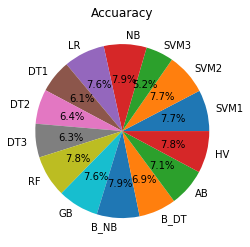

In [0]:
lab = ['SVM1', 'SVM2','SVM3','NB', 'LR', 'DT1', 'DT2', 'DT3', 'RF', 'GB', 'B_NB', 'B_DT','AB', 'HV' ]
plt.pie(acc,autopct='%.1f%%',labels=lab,)
plt.title('Accuaracy')
plt.show()

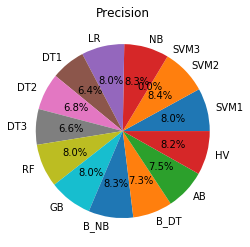

In [0]:
lab = ['SVM1', 'SVM2','SVM3','NB', 'LR', 'DT1', 'DT2', 'DT3', 'RF', 'GB', 'B_NB', 'B_DT','AB', 'HV' ]
plt.pie(pre,autopct='%.1f%%',labels=lab,)
plt.title('Precision')
plt.show()

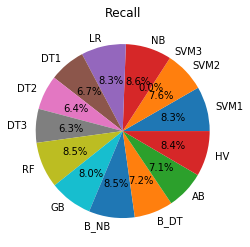

In [0]:
lab = ['SVM1', 'SVM2','SVM3','NB', 'LR', 'DT1', 'DT2', 'DT3', 'RF', 'GB', 'B_NB', 'B_DT','AB', 'HV' ]
plt.pie(rec,autopct='%.1f%%',labels=lab,)
plt.title('Recall')
plt.show()

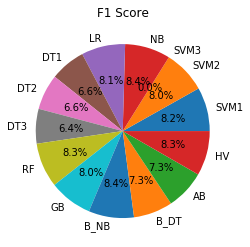

In [0]:
lab = ['SVM1', 'SVM2','SVM3','NB', 'LR', 'DT1', 'DT2', 'DT3', 'RF', 'GB', 'B_NB', 'B_DT','AB', 'HV' ]
plt.pie(f,autopct='%.1f%%',labels=lab,)
plt.title('F1 Score')
plt.show()

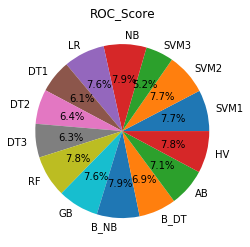

In [0]:
lab = ['SVM1','SVM2','SVM3', 'NB', 'LR', 'DT1', 'DT2', 'DT3', 'RF', 'GB', 'B_NB', 'B_DT','AB', 'HV' ]
plt.pie(ro,autopct='%.1f%%',labels=lab,)
plt.title('ROC_Score')
plt.show()